# Run

## Imports

In [1]:
! pip install backtesting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 8.3 MB/s eta 0:00:00


In [2]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.0 MB/s eta 0:00:00


In [3]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-10-09 05:17:32--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-10-09 05:17:32--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

### Get Binance klines

In [5]:
from datetime import timezone, datetime
import os
import requests
import zipfile
import csv
import io
from dateutil.relativedelta import relativedelta

def generate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')
    months = []

    while start_date <= end_date:
        months.append(start_date.strftime('%Y-%m'))
        start_date = start_date + relativedelta(months=1)

    return months


# Загрузка данных с Binance
def download_klines(symbol, interval, start_date, end_date):
    months = generate_months(start_date, end_date)
    if not os.path.exists('klines'):
        os.mkdir('klines')

    klines = {
        'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []
    }

    for month in months:
        filename = f"{symbol}-{interval}-{month}.zip"
        file_path = f"klines/{filename}"

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol}/{interval}/{filename}"
            try:
                r = requests.get(url, allow_redirects=True)
                with open(file_path, 'wb') as f:
                    f.write(r.content)
            except Exception as e:
                print(f"Ошибка загрузки файла {filename}: {e}. Пропускаем.")
                continue

        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                with zip_file.open(f"{symbol}-{interval}-{month}.csv", 'r') as csv_file:
                    csv_reader = csv.reader(io.TextIOWrapper(csv_file, 'utf-8'))
                    for row in csv_reader:
                        if row[0].isdigit():
                            klines['Date'].append(datetime.fromtimestamp(int(row[0]) / 1000, tz=timezone.utc))
                            klines['Open'].append(float(row[1]))
                            klines['High'].append(float(row[2]))
                            klines['Low'].append(float(row[3]))
                            klines['Close'].append(float(row[4]))
                            klines['Volume'].append(float(row[5]))
        except (zipfile.BadZipFile, KeyError):
            print(f"Ошибка: Файл {file_path} поврежден или не является ZIP. Пропускаем.")
            continue


    if not klines['Date']:
        raise ValueError(f"Нет доступных данных для {symbol} в диапазоне {start_date} - {end_date}")

    df = pd.DataFrame(klines)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

### Candle patterns

In [6]:
import numpy as np
import pandas as pd

def detect_candlestick_patterns(
    df,
    doji_th=0.1,
    hammer_lower_mult=2.0,
    hammer_upper_mult=0.3,
    small_body_factor=0.5,
    min_body_pct=0.2
):
    df = df.copy()
    o = df['open'].astype(float)
    h = df['high'].astype(float)
    l = df['low'].astype(float)
    c = df['close'].astype(float)

    prev_o = o.shift(1); prev_h = h.shift(1); prev_l = l.shift(1); prev_c = c.shift(1)
    pre_prev_o = o.shift(2); pre_prev_c = c.shift(2)

    # --- Базовые величины ---
    df['body'] = c - o
    df['body_abs'] = df['body'].abs()
    df['range'] = (h - l).replace(0, np.nan)
    df['upper_shadow'] = h - np.maximum(o, c)
    df['lower_shadow'] = np.minimum(o, c) - l
    df['body_pct_of_range'] = df['body_abs'] / df['range']

    # --- Doji ---
    df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | \
                 (df['body_abs'] <= doji_th * df['range'])

    # --- Hammer (бычий сигнал) ---
    df['hammer'] = (
        (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Inverted Hammer ---
    df['inverted_hammer'] = (
        (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Bullish Engulfing ---
    prev_body_abs = (prev_c - prev_o).abs()
    df['bullish_engulfing'] = (
        (prev_c < prev_o) & (c > o) & (o < prev_c) & (c > prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Bearish Engulfing ---
    df['bearish_engulfing'] = (
        (prev_c > prev_o) & (c < o) & (o > prev_c) & (c < prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Piercing Line (бычий) ---
    df['piercing_line'] = (
        (prev_c < prev_o) & (o < prev_c) & (c > (prev_o + prev_c) / 2)
    ).fillna(False)

    # --- Dark Cloud Cover (медвежий) ---
    df['dark_cloud'] = (
        (prev_c > prev_o) & (o > prev_h) & (c < (prev_o + prev_c) / 2) & (c > prev_o)
    ).fillna(False)

    # --- Morning Star (бычий, 3 свечи) ---
    prev_body_abs = (prev_c - prev_o).abs()
    pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
    df['morning_star'] = (
        (pre_prev_c < pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c > o) & (c > (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Evening Star (медвежий, 3 свечи) ---
    df['evening_star'] = (
        (pre_prev_c > pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c < o) & (c < (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Three White Soldiers ---
    o0, o1, o2 = o.shift(2), o.shift(1), o
    c0, c1, c2 = c.shift(2), c.shift(1), c
    df['three_white_soldiers'] = (
        (c0 > o0) & (c1 > o1) & (c2 > o2) &
        (c2 > c1) & (c1 > c0) &
        (o1 > o0) & (o2 > o1)
    ).fillna(False)

    # --- Three Black Crows (медвежий аналог) ---
    df['three_black_crows'] = (
        (c0 < o0) & (c1 < o1) & (c2 < o2) &
        (c2 < c1) & (c1 < c0) &
        (o1 < o0) & (o2 < o1)
    ).fillna(False)

    # --- Harami Cross ---
    prev_body_top = np.maximum(prev_o, prev_c)
    prev_body_bottom = np.minimum(prev_o, prev_c)
    harami_cross = (
        df['doji'] & (h < prev_body_top) & (l > prev_body_bottom) &
        (prev_body_abs >= (min_body_pct * df['range'].shift(1)))
    )
    df['harami_cross'] = harami_cross.fillna(False)

    # --- Bearish Harami ---
    df['bearish_harami'] = (
        (prev_c > prev_o) & (c < o) &
        (h < prev_c) & (l > prev_o)
    ).fillna(False)

    # Очистка вспомогательных колонок
    df = df.drop(columns=[
        'body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'
    ])

    return df


In [7]:
# import numpy as np
# import pandas as pd

# def detect_candlestick_patterns(df,
#                                 doji_th=0.1,               # doji: тело <= 10% от range
#                                 hammer_lower_mult=2.0,     # lower_shadow >= 2 * body
#                                 hammer_upper_mult=0.3,     # upper_shadow <= 0.3 * body
#                                 small_body_factor=0.5,     # middle candle size relative threshold for morning star
#                                 min_body_pct=0.2):         # minimum body size relative to candle range for "strong" bodies
#     # ASSUME df has numeric columns: 'open','high','low','close'
#     df = df.copy()

#     o = df['open'].astype(float)
#     h = df['high'].astype(float)
#     l = df['low'].astype(float)
#     c = df['close'].astype(float)

#     prev_o = o.shift(1)
#     prev_h = h.shift(1)
#     prev_l = l.shift(1)
#     prev_c = c.shift(1)

#     pre_prev_o = o.shift(2)
#     pre_prev_c = c.shift(2)

#     # basic measures
#     df['body'] = c - o
#     df['body_abs'] = df['body'].abs()
#     df['range'] = (h - l).replace(0, np.nan)   # avoid div by zero, keep NaN for zero-range
#     df['upper_shadow'] = h - np.maximum(o, c)
#     df['lower_shadow'] = np.minimum(o, c) - l
#     df['body_pct_of_range'] = df['body_abs'] / df['range']

#     # DOJI (relative to candle range)
#     df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | (df['body_abs'] <= doji_th * df['range'])

#     # HAMMER (both bullish or bearish allowed)
#     hammer_cond = (
#         (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)   # body not too large relative to range
#     )
#     df['hammer'] = hammer_cond

#     # INVERTED HAMMER
#     inv_hammer_cond = (
#         (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)
#     )
#     df['inverted_hammer'] = inv_hammer_cond

#     # BULLISH ENGULFING
#     prev_body_abs = (prev_c - prev_o).abs()
#     bull_engulf = (
#         (prev_c < prev_o) &           # previous bearish
#         (c > o) &                     # current bullish
#         (o < prev_c) &                # current open below previous close (i.e. below previous body top)
#         (c > prev_o) &                # current close above previous open (engulf)
#         (df['body_abs'] > prev_body_abs)  # optional: current body bigger than previous
#     )
#     df['bullish_engulfing'] = bull_engulf.fillna(False)

#     # PIERCING LINE (classic definition)
#     piercing = (
#         (prev_c < prev_o) &  # prev bearish
#         (o < prev_l) &       # current open below previous low (gap down) -- can relax to prev_c if desired
#         (c > (prev_o + prev_c) / 2)  # close into upper half of previous body
#     )
#     df['piercing_line'] = piercing.fillna(False)

#     # MORNING STAR (3-candle pattern)
#     # 1) pre_prev bearish
#     # 2) previous small body relative to pre_prev
#     # 3) current bullish and closes above midpoint of pre_prev body
#     prev_body_abs = (prev_c - prev_o).abs()
#     pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
#     morning_star = (
#         (pre_prev_c < pre_prev_o) &
#         (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
#         (c > o) &
#         (o < prev_c) &  # current opens below previous close (gap or inside)
#         (c > (pre_prev_o + pre_prev_c) / 2)
#     )
#     df['morning_star'] = morning_star.fillna(False)

#     # THREE WHITE SOLDIERS (vectorized)
#     o0 = o.shift(2); o1 = o.shift(1); o2 = o
#     c0 = c.shift(2); c1 = c.shift(1); c2 = c
#     body0 = (c0 - o0).abs(); body1 = (c1 - o1).abs(); body2 = (c2 - o2).abs()
#     three_ws = (
#         (c0 > o0) & (c1 > o1) & (c2 > o2) &               # all bullish
#         (c2 > c1) & (c1 > c0) &                            # ascending closes
#         (o1 > o0) & (o2 > o1) &                            # opens move upward
#         (body0 >= min_body_pct * (h.shift(2) - l.shift(2)).replace(0, np.nan)) &
#         (body1 >= min_body_pct * (h.shift(1) - l.shift(1)).replace(0, np.nan)) &
#         (body2 >= min_body_pct * (h - l).replace(0, np.nan)) &
#         (o1 < c0) & (o2 < c1)                              # opens within previous bodies (not strict gap)
#     )
#     df['three_white_soldiers'] = three_ws.fillna(False)

#     # HARAMI CROSS (doji inside previous real body) — generalized both directions
#     prev_body_top = np.maximum(prev_o, prev_c)
#     prev_body_bottom = np.minimum(prev_o, prev_c)
#     harami_cross = (
#         df['doji'] &
#         (df['high'] < prev_body_top) &
#         (df['low'] > prev_body_bottom) &
#         (prev_body_abs >= (min_body_pct * df['range'].shift(1)))  # prev body not tiny
#     )
#     df['harami_cross'] = harami_cross.fillna(False)

#     # clean helper columns if you like
#     df = df.drop(columns=['body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'])
#     return df


In [8]:
# # functions for calculating patterns
# import pandas as pd

# def is_doji(row, threshold=0.1):
#     return abs(row['open'] - row['close']) <= threshold

# def is_hammer(row):
#     body = abs(row['open'] - row['close'])
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     return lower_shadow > 2 * body and upper_shadow < body

# def is_bullish_engulfing(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#            current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

# def is_piercing_line(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#             current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

# def is_morning_star(current_row, previous_row, pre_previous_row):
#     return pre_previous_row['close'] < pre_previous_row['open'] and \
#           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
#           current_row['close'] > current_row['open'] and \
#           current_row['open'] < previous_row['close'] and \
#           current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

# def is_inverted_hammer(row):
#     body = abs(row['open'] - row['close'])
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     return upper_shadow > 2 * body and lower_shadow < body

# def is_three_white_soldiers(df, idx):
#     if idx < 2:
#         return False
#     current = df.iloc[idx]
#     prev1 = df.iloc[idx - 1]
#     prev2 = df.iloc[idx - 2]
#     return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
#            all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
#            all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

# def is_harami_cross(current_row, previous_row):
#     return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
#            previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

# data['doji'] = data.apply(is_doji, axis=1)
# data['hammer'] = data.apply(is_hammer, axis=1)
# data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
# data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
# data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
# data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [9]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from google.colab import files
import shutil
import matplotlib.dates as mdates

def save_all_patterns(
    data,
    pattern_column='Pattern',
    output_root='patterns',
    symbol='BTCUSDT',
    interval='1h',
    bars_before=20,
    bars_after=20,
    max_samples_per_pattern=10,
    min_window_bars=5,
    global_scale_tol=10.0,        # допустимое отклонение медианной цены окна от глобальной медианы
    price_quantiles=(0.01, 0.99)  # квантили для ylim
):
    """
    Надёжная версия сохранения паттернов: защищена от выбросов/NaN/tz-артефактов.
    """
    df = data.copy()

    # --- Найдём колонку pattern_column без учёта регистра ---
    if pattern_column not in df.columns:
        matches = [c for c in df.columns if c.lower() == pattern_column.lower()]
        if matches:
            pattern_column = matches[0]
        else:
            raise ValueError(f"Column '{pattern_column}' not found (case-insensitive search failed).")

    # --- Приведение имён столбцов ---
    rename_map = {}
    for col in df.columns:
        cl = col.lower()
        if cl == 'open': rename_map[col] = 'Open'
        elif cl == 'high': rename_map[col] = 'High'
        elif cl == 'low': rename_map[col] = 'Low'
        elif cl == 'close': rename_map[col] = 'Close'
        elif cl == 'volume': rename_map[col] = 'Volume'
    df = df.rename(columns=rename_map)

    required = {'Open','High','Low','Close'}
    if not required.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns {required}. Found: {list(df.columns)}")

    # --- DatetimeIndex и tz-naive ---
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
        else:
            raise ValueError("DataFrame must have DatetimeIndex or a 'Date' column")
    df = df.sort_index()
    if getattr(df.index, 'tz', None) is not None:
        try:
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        except Exception:
            df.index = df.index.tz_localize(None)

    # --- глобальные метрики для детекции аномалий ---
    global_close_median = float(df['Close'].median(skipna=True))
    global_price_range_median = float((df['High'] - df['Low']).median(skipna=True) if 'High' in df.columns else 0.0)

    # --- подготовка вывода и логов ---
    os.makedirs(output_root, exist_ok=True)
    skipped = []  # список (idx, reason)

    patterns = df[pattern_column].dropna().unique()
    print(f"🔍 Найдено {len(patterns)} уникальных паттернов")

    for pattern_name in patterns:
        subset = df[df[pattern_column] == pattern_name]
        count = len(subset)
        print(f"📊 {pattern_name}: {count} случаев")

        if count == 0:
            continue

        pattern_dir = os.path.join(output_root, str(pattern_name))
        os.makedirs(pattern_dir, exist_ok=True)

        # случайные индексы примеров
        sample_indices = random.sample(list(subset.index), min(count, max_samples_per_pattern))

        for idx in sample_indices:
            try:
                center = df.index.get_loc(idx)
                start = max(0, center - bars_before)
                end = min(len(df) - 1, center + bars_after)
                window = df.iloc[start:end+1].copy()

                # Быстрые проверки окна
                if len(window) < min_window_bars:
                    skipped.append((idx, 'too few bars'))
                    continue
                if window[['Open','High','Low','Close']].isnull().any().any():
                    skipped.append((idx, 'contains NaN'))
                    continue
                # High must be >= Low for all rows
                if (window['High'] < window['Low']).any():
                    skipped.append((idx, 'High < Low in window'))
                    continue

                # масштаб окна относительно глобального
                win_median = float(window['Close'].median())
                if (win_median / global_close_median > global_scale_tol) or (global_close_median / win_median > global_scale_tol):
                    skipped.append((idx, 'scale mismatch (different units or outlier)'))
                    continue

                # вычисляем квантильные границы для ylim, добавляем padding
                low_q, high_q = window['Low'].quantile(price_quantiles[0]), window['High'].quantile(price_quantiles[1])
                if pd.isna(low_q) or pd.isna(high_q):
                    skipped.append((idx, 'quantile computation failed'))
                    continue
                pad = (high_q - low_q) * 0.15 if (high_q - low_q) > 0 else max(1e-6, 0.01 * abs(win_median))
                ylim = (low_q - pad, high_q + pad)

                # корректный timedelta между свечами -> для axvspan
                if len(window.index) >= 2:
                    time_delta = window.index[1] - window.index[0]
                else:
                    # резерв: взять средний delta по df
                    time_delta = (df.index.to_series().diff().median() or pd.Timedelta(hours=1))
                half_span_days = (time_delta / 2) / pd.Timedelta(days=1)

                # Приведение window.index к tz-naive (ещё раз)
                try:
                    if getattr(window.index, 'tz', None) is not None:
                        window.index = window.index.tz_convert('UTC').tz_localize(None)
                except Exception:
                    try:
                        window.index = window.index.tz_localize(None)
                    except Exception:
                        window.index = pd.to_datetime(window.index)

                # Построение графика с принудительным ylim
                title = f"{pattern_name} ({symbol}, {interval}) — {pd.to_datetime(idx).strftime('%Y-%m-%d %H:%M')}"
                fig, axlist = mpf.plot(
                    window,
                    type='candle',
                    style='nightclouds',
                    volume=True,
                    returnfig=True,
                    figsize=(12, 6),
                    title=title,
                    show_nontrading=True
                )

                ax_price = axlist[0]

                # Устанавливаем ylim (защита от выбросов)
                try:
                    ax_price.set_ylim(ylim)
                except Exception:
                    # если не получилось — игнорируем
                    pass

                # координаты для аннотаций в числовом формате matplotlib
                x_num = mdates.date2num(pd.to_datetime(idx))

                row = df.loc[idx]
                high_val = row.get('High', row.get('high'))
                low_val = row.get('Low', row.get('low'))

                if pd.isna(high_val) or pd.isna(low_val):
                    skipped.append((idx, 'High/Low NaN for annotation'))
                    plt.close(fig)
                    continue

                price_range = float(high_val) - float(low_val)
                arrow_offset = price_range * 0.12 if price_range > 0 else max(1e-6, 0.001 * abs(win_median))

                # отрисовка стрелки и подсветки (используем числовые X)
                ax_price.annotate(
                    '',
                    xy=(x_num, float(high_val)),
                    xytext=(x_num, float(high_val) + arrow_offset),
                    xycoords='data',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5)
                )

                start_x = x_num - half_span_days
                end_x = x_num + half_span_days
                ax_price.axvspan(start_x, end_x, color='magenta', alpha=0.18)

                ax_price.text(
                    x_num, float(high_val) + arrow_offset * 1.05,
                    str(pattern_name),
                    ha='center', va='bottom',
                    fontsize=10, color='magenta', weight='bold'
                )

                ax_price.xaxis_date()
                fig.tight_layout()

                filename = f"{pattern_name}_{symbol}_{interval}_{pd.to_datetime(idx).strftime('%Y-%m-%d_%H-%M')}.png"
                filepath = os.path.join(pattern_dir, filename)
                fig.savefig(filepath, dpi=150, bbox_inches='tight')
                plt.close(fig)

            except Exception as e:
                skipped.append((idx, f'exception: {e}'))
                try:
                    plt.close('all')
                except Exception:
                    pass
                continue

    # Сохраняем лог пропусков
    if skipped:
        skipped_df = pd.DataFrame(skipped, columns=['index', 'reason']).set_index('index')
        skipped_log = os.path.join(output_root, '_skipped.csv')
        skipped_df.to_csv(skipped_log)
        print(f"⚠️ Сохранён лог пропущенных случаев: {skipped_log} (пример: index,reason)")

    # Архив и скачивание (Colab)
    zip_path = f"{output_root}.zip"
    if os.path.exists(zip_path):
        os.remove(zip_path)
    shutil.make_archive(output_root, 'zip', output_root)
    print(f"\n✅ Готово. Графики в папке: {os.path.abspath(output_root)}; архив: {zip_path}")

    try:
        files.download(zip_path)
        print("⬇️ Скачивание архива запущено...")
    except Exception:
        print("⚠️ Автозагрузка ZIP невозможна (не Colab). Архив:", os.path.abspath(zip_path))







### Stationarity

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series, p_threshold=0.05):
    """Проверка стационарности ряда через ADF-тест"""
    series = series.dropna()
    if series.nunique() < 2:  # слишком мало уникальных значений
        return False
    try:
        result = adfuller(series)
        p_value = result[1]
        t_test = result[0] < result[4]["5%"]
        return p_value < p_threshold and t_test
    except Exception:
        return False



def make_stationary(data, p_threshold=0.05):
    """
    Проверяет все признаки на стационарность и приводит нестационарные к стационарному виду.
    data - DataFrame с фичами
    """
    df = data.copy()
    non_stationaries = []

    # 1. Проверяем исходные признаки
    for col in df.columns:
        col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(col_data) > 10 and not adf_test(col_data, p_threshold=p_threshold):
            non_stationaries.append(col)

    print(f"Нестационарные признаки: {len(non_stationaries)}")

    # 2. Пробуем разные трансформации
    for col in non_stationaries:
        transformed = None
        col_data = df[col].replace([np.inf, -np.inf], np.nan)

        # Попробуем log (только для положительных)
        if (col_data > 0).all():
            log_series = np.log(col_data)
            if adf_test(log_series, p_threshold):
                transformed = log_series
            else:
                # log + diff
                log_diff = np.log(col_data).diff()
                if adf_test(log_diff.dropna(), p_threshold):
                    transformed = log_diff

        # Если log не помог → diff
        if transformed is None:
            diff_series = col_data.diff()
            if adf_test(diff_series.dropna(), p_threshold):
                transformed = diff_series

        # Если ничего не сработало → просто diff
        if transformed is None:
            transformed = col_data.diff()

        df[col] = transformed

    # 3. Удаляем первые NaN после разностей
    df = df.dropna()

    return df

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from joblib import Parallel, delayed

# --- быстрый тест через автокорреляцию
def is_stationary_fast(series, threshold=0.95):
    """Быстрая проверка стационарности через автокорреляцию"""
    series = series.dropna()
    if len(series) < 10:
        return True
    corr = series.autocorr(lag=1)
    return abs(corr) < threshold

# --- ADF тест с обрезкой длины
def adf_test(series, p_threshold=0.05, max_len=1000):
    """Проверка стационарности ряда через ADF"""
    series = series.dropna()
    if len(series) > max_len:
        series = series.tail(max_len)
    if series.nunique() < 2:
        return False
    try:
        result = adfuller(series, autolag="AIC")
        p_value = result[1]
        t_test = result[0] < result[4]["5%"]
        return p_value < p_threshold and t_test
    except Exception:
        return False

# --- обработка одной колонки
def process_column(col_data, p_threshold=0.05):
    col_data = col_data.replace([np.inf, -np.inf], np.nan).dropna()

    if len(col_data) < 10:
        return col_data  # слишком мало данных

    # быстрый фильтр
    if is_stationary_fast(col_data):
        return col_data

    # ADF-проверка
    if not adf_test(col_data, p_threshold):
        # пробуем преобразования
        transformed = None

        # log
        if (col_data > 0).all():
            log_series = np.log(col_data)
            if adf_test(log_series, p_threshold):
                transformed = log_series
            else:
                log_diff = np.log(col_data).diff()
                if adf_test(log_diff, p_threshold):
                    transformed = log_diff

        # diff
        if transformed is None:
            diff_series = col_data.diff()
            if adf_test(diff_series, p_threshold):
                transformed = diff_series

        if transformed is None:
            transformed = col_data.diff()

        return transformed.dropna()

    return col_data

# --- главная функция
def make_stationary(data, p_threshold=0.05, n_jobs=-1):
    """
    Проверяет все признаки на стационарность и приводит их к стационарному виду.
    data - DataFrame с фичами
    """
    df = data.copy()

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_column)(df[col], p_threshold) for col in df.columns
    )

    df = pd.concat(results, axis=1)
    df.columns = data.columns
    df = df.dropna()
    return df

In [12]:
# from statsmodels.tsa.stattools import adfuller
# import numpy as np

# non_stationaries = []

# for col in df_stationary.columns:
#     # Replace infinite values with NaN and drop NaN values for the current column
#     col_data = df_stationary[col].replace([np.inf, -np.inf], np.nan).dropna()

#     if col_data.nunique() > 1:  # Проверка на различные значения в столбце
#         # Ensure there are enough data points after dropping NaNs for the test
#         if len(col_data) > 0:
#             try:
#                 dftest = adfuller(col_data.values)
#                 p_value = dftest[1]
#                 # Check if the test statistic is less than the 1% critical value
#                 t_test = dftest[0] < dftest[4]["1%"]
#                 if p_value > 0.05 or not t_test:
#                     non_stationaries.append(col)
#             except ValueError:
#                  # Handle cases where adfuller might still fail (e.g., not enough variation)
#                  print(f"Could not perform ADF test on column {col}")

# print(f"Non-Stationary Features Found: {len(non_stationaries)}")

### EDA

In [13]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        # skipping the object type
        if dataframe[column].dtype == 'object':
            break

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [14]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 38.4 MB/s eta 0:00:00


In [15]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    if len(correlation_types) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
        axes = [axes] # Wrap the single axes object in a list for consistent indexing
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))


    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [16]:
# Function to find multicollinearity and print correlation matrix
# !pip install phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.nan)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Data extraction

In [54]:
# Data extraction
symbol = 'WIFUSDT'
interval = '30m'
start_date = '2024-09'
end_date = '2025-09'

data_klines = download_klines(symbol, interval, start_date, end_date)
data = data_klines.copy()

In [55]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [56]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2024-09-01 00:00:00+00:00,1.5166,1.5188,1.5055,1.5116,7200682.7
2024-09-01 00:30:00+00:00,1.5116,1.5266,1.5109,1.5191,4280155.8
2024-09-01 01:00:00+00:00,1.5192,1.5232,1.5094,1.5112,3222538.5
2024-09-01 01:30:00+00:00,1.5111,1.5116,1.4915,1.4948,6361003.9
2024-09-01 02:00:00+00:00,1.4947,1.4954,1.4762,1.4821,10260637.0
...,...,...,...,...,...
2025-09-30 21:30:00+00:00,0.7230,0.7265,0.7217,0.7221,3524445.9
2025-09-30 22:00:00+00:00,0.7221,0.7275,0.7220,0.7246,2759510.6
2025-09-30 22:30:00+00:00,0.7246,0.7252,0.7193,0.7201,3326768.5


In [57]:
data.columns = data.columns.str.lower()
data.head()

,open,high,low,close,volume
Date,,,,,
2024-09-01 00:00:00+00:00,1.5166,1.5188,1.5055,1.5116,7200682.7
2024-09-01 00:30:00+00:00,1.5116,1.5266,1.5109,1.5191,4280155.8
2024-09-01 01:00:00+00:00,1.5192,1.5232,1.5094,1.5112,3222538.5
2024-09-01 01:30:00+00:00,1.5111,1.5116,1.4915,1.4948,6361003.9
2024-09-01 02:00:00+00:00,1.4947,1.4954,1.4762,1.4821,10260637.0


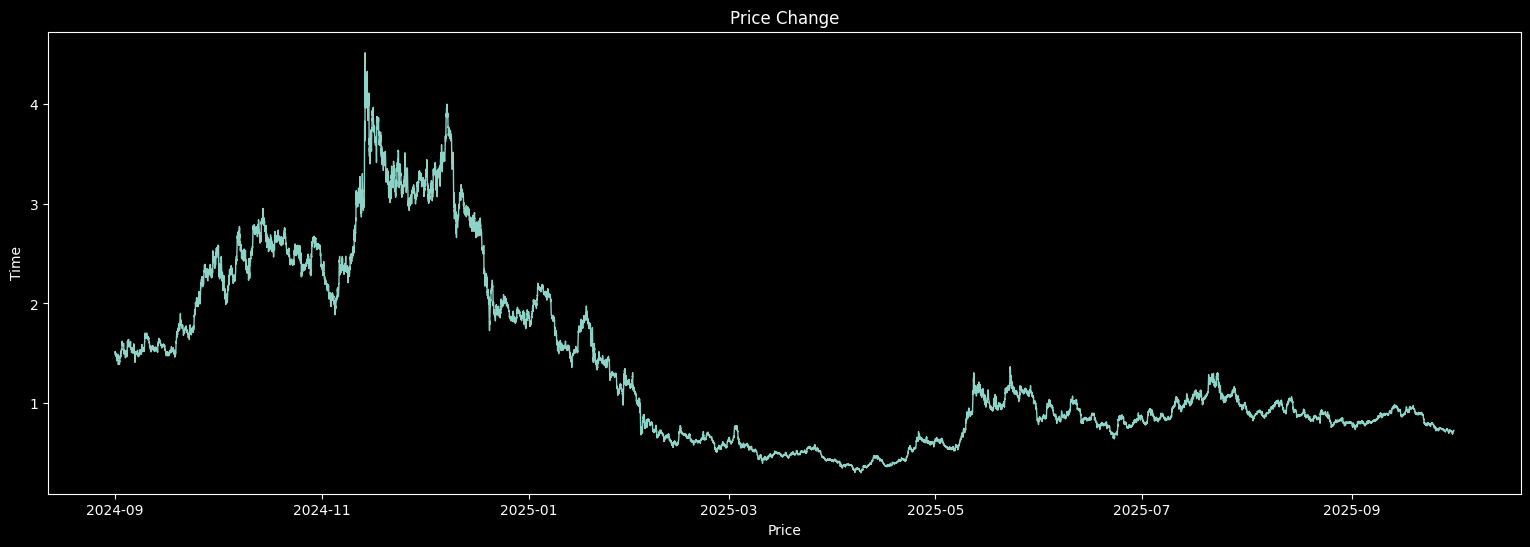

In [58]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.grid()
plt.show()


## Data Preprocessing - Stationarity

In [91]:
df_stationary = make_stationary(data)
df_stationary.head()

,open,high,low,close,volume,doji,hammer,inverted_hammer,bullish_engulfing,bearish_engulfing,piercing_line,dark_cloud,morning_star,evening_star,three_white_soldiers,three_black_crows,bearish_harami
Date,,,,,,,,,,,,,,,,,
2024-09-01 00:30:00+00:00,-0.003302,0.005122,0.003580,0.004949,4280155.8,False,False,False,False,False,False,False,False,False,False,False,False
2024-09-01 01:00:00+00:00,0.005015,-0.002230,-0.000993,-0.005214,3222538.5,False,False,False,False,True,False,False,False,False,False,False,False
2024-09-01 01:30:00+00:00,-0.005346,-0.007645,-0.011930,-0.010912,6361003.9,False,False,False,False,False,False,False,False,False,False,False,False
2024-09-01 02:00:00+00:00,-0.010912,-0.010775,-0.010311,-0.008532,10260637.0,False,False,False,False,False,False,False,False,False,False,True,False
2024-09-01 02:30:00+00:00,-0.008466,0.001604,0.002909,0.010137,3965795.0,False,False,False,False,False,False,False,False,False,False,False,False


In [92]:
df_stationary.isna().sum()

,0
open,0
high,0
low,0
close,0
volume,0
doji,0
hammer,0
inverted_hammer,0
bullish_engulfing,0
bearish_engulfing,0


## Candle patterns

In [59]:
data = detect_candlestick_patterns(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18960 entries, 2024-09-01 00:00:00+00:00 to 2025-09-30 23:30:00+00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  18960 non-null  float64
 1   high                  18960 non-null  float64
 2   low                   18960 non-null  float64
 3   close                 18960 non-null  float64
 4   volume                18960 non-null  float64
 5   doji                  18960 non-null  bool   
 6   hammer                18960 non-null  bool   
 7   inverted_hammer       18960 non-null  bool   
 8   bullish_engulfing     18960 non-null  bool   
 9   bearish_engulfing     18960 non-null  bool   
 10  piercing_line         18960 non-null  bool   
 11  dark_cloud            18960 non-null  bool   
 12  morning_star          18960 non-null  bool   
 13  evening_star          18960 non-null  bool   
 14  three_white_soldiers  1

In [60]:
import numpy as np
import pandas as pd


def detect_candlestick_patterns_v2(df,
    atr_period=14,
    doji_th=0.15,
    hammer_lower_mult=2.0,
    hammer_upper_mult=0.3,
    small_body_factor=0.4,
    min_body_atr=0.15,        # минимальный размер тела в долях ATR
    vol_ma_period=20,
    vol_mult_bonus=1.2,       # бонус к силе, если объём > vol_ma * vol_mult_bonus
    pattern_weights=None      # можно задать веса для отдельных паттернов
):
    """
    Возвращает df с колонками:
      'Pattern'          — название паттерна (или NaN)
      'Signal'           — 1 (бычий), -1 (медвежий), 0 (нет сигнала)
      'Signal_strength'  — сила сигнала (0–5)
      'ATR'              — значение среднего истинного диапазона

    Требует DataFrame с колонками Open, High, Low, Close (+ Volume опционально).
    """

    # --- Веса паттернов ---
    if pattern_weights is None:
        pattern_weights = {
            'bullish_engulfing': 1.2,
            'bearish_engulfing': 1.2,
            'piercing_line': 1.0,
            'dark_cloud': 1.0,
            'hammer': 0.9,
            'inverted_hammer': 0.9,
            'morning_star': 1.3,
            'evening_star': 1.3,
            'three_white_soldiers': 1.4,
            'three_black_crows': 1.4,
            'harami_cross': 0.8
        }

    df = df.copy()

    # --- Нормализация имен колонок ---
    colmap = {}
    for name in ['Open','High','Low','Close','Volume']:
        if name in df.columns:
            colmap[name] = name
        elif name.lower() in df.columns:
            colmap[name] = name.lower()
        else:
            colmap[name] = None

    if colmap['Open'] is None or colmap['High'] is None or colmap['Low'] is None or colmap['Close'] is None:
        raise ValueError("DataFrame must contain Open/High/Low/Close (case-insensitive)")

    O = df[colmap['Open']].astype(float)
    H = df[colmap['High']].astype(float)
    L = df[colmap['Low']].astype(float)
    C = df[colmap['Close']].astype(float)
    V = df[colmap['Volume']] if colmap['Volume'] is not None else None

    prev_O = O.shift(1)
    prev_H = H.shift(1)
    prev_L = L.shift(1)
    prev_C = C.shift(1)
    pre_prev_O = O.shift(2)
    pre_prev_C = C.shift(2)

    # --- ATR ---
    tr = pd.concat([
        (H - L).abs(),
        (H - prev_C).abs(),
        (L - prev_C).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(atr_period, min_periods=1).mean()

    # --- Расчёты тела и теней ---
    body = C - O
    body_abs = body.abs()
    upper_shadow = H - np.maximum(O, C)
    lower_shadow = np.minimum(O, C) - L
    rng = (H - L).replace(0, np.nan)
    body_pct_of_range = body_abs / rng

    # --- Volume MA ---
    if V is not None:
        vol_ma = V.rolling(vol_ma_period, min_periods=1).mean()
    else:
        vol_ma = None

    # --- Минимальный размер тела ---
    min_body = min_body_atr * atr

    # --- Doji ---
    is_doji = (body_abs <= doji_th * rng) | (rng == 0)

    # --- Hammer / Inverted Hammer ---
    hammer = (
        (lower_shadow >= hammer_lower_mult * body_abs) &
        (upper_shadow <= hammer_upper_mult * body_abs) &
        (body_pct_of_range <= 0.5) &
        (body_abs >= min_body)
    )

    inverted_hammer = (
        (upper_shadow >= hammer_lower_mult * body_abs) &
        (lower_shadow <= hammer_upper_mult * body_abs) &
        (body_pct_of_range <= 0.5) &
        (body_abs >= min_body)
    )

    # --- Engulfing ---
    prev_body_abs = (prev_C - prev_O).abs()
    bullish_engulfing = (
        (prev_C < prev_O) &
        (C > O) &
        (O <= prev_C) & (C >= prev_O) &
        (body_abs > prev_body_abs) &
        (body_abs >= min_body)
    )

    bearish_engulfing = (
        (prev_C > prev_O) &
        (C < O) &
        (O >= prev_C) & (C <= prev_O) &
        (body_abs > prev_body_abs) &
        (body_abs >= min_body)
    )

    # --- Piercing / Dark Cloud ---
    prev_mid = (prev_O + prev_C) / 2.0
    piercing = (
        (prev_C < prev_O) &
        (O < prev_L) &
        (C > prev_mid) &
        (C < prev_O) &
        (body_abs >= min_body)
    )

    dark_cloud = (
        (prev_C > prev_O) &
        (O > prev_H) &
        (C < prev_mid) &
        (C > prev_O) &
        (body_abs >= min_body)
    )

    # --- Morning / Evening Star ---
    pre_prev_body_abs = (pre_prev_C - pre_prev_O).abs()

    morning_star = (
        (pre_prev_C < pre_prev_O) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (C > O) &
        (C > (pre_prev_O + pre_prev_C) / 2.0) &
        (body_abs >= min_body)
    )

    evening_star = (
        (pre_prev_C > pre_prev_O) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (C < O) &
        (C < (pre_prev_O + pre_prev_C) / 2.0) &
        (body_abs >= min_body)
    )

    # --- Three White Soldiers / Three Black Crows ---
    o0, o1, o2 = O.shift(2), O.shift(1), O
    c0, c1, c2 = C.shift(2), C.shift(1), C

    tws = (
        (c0 > o0) & (c1 > o1) & (c2 > o2) &
        (c2 > c1) & (c1 > c0) &
        (o1 > o0) & (o2 > o1) &
        ((c0 - o0) >= min_body) &
        ((c1 - o1) >= min_body) &
        ((c2 - o2) >= min_body)
    )

    tbc = (
        (c0 < o0) & (c1 < o1) & (c2 < o2) &
        (c2 < c1) & (c1 < c0) &
        (o1 < o0) & (o2 < o1) &
        ((o0 - c0) >= min_body) &
        ((o1 - c1) >= min_body) &
        ((o2 - c2) >= min_body)
    )

    # --- Harami Cross ---
    prev_body_top = np.maximum(prev_O, prev_C)
    prev_body_bot = np.minimum(prev_O, prev_C)
    harami_cross = (
        is_doji &
        (H < prev_body_top) &
        (L > prev_body_bot) &
        (prev_body_abs >= 0.5 * rng.shift(1).fillna(0))
    )

    # --- Сбор паттернов ---
    n = len(df)
    pattern = pd.Series([None]*n, index=df.index, dtype="object")
    signal = pd.Series(0, index=df.index, dtype="int")
    strength = pd.Series(0.0, index=df.index, dtype="float")

    def add_pattern(mask, name, dir_sign):
        w = pattern_weights.get(name, 1.0)
        base = (body_abs / atr).clip(lower=0).fillna(0)
        s = base * w

        if vol_ma is not None:
            vol_bonus = (V > vol_ma * vol_mult_bonus).astype(float)
            s *= (1.0 + 0.3 * vol_bonus)

        idx = mask.fillna(False)
        replace_idx = idx & (s > strength)
        pattern.loc[replace_idx] = name
        signal.loc[replace_idx] = dir_sign
        strength.loc[replace_idx] = s.loc[replace_idx]

    # --- Добавляем все паттерны ---
    add_pattern(bullish_engulfing, 'bullish_engulfing', 1)
    add_pattern(bearish_engulfing, 'bearish_engulfing', -1)
    add_pattern(piercing, 'piercing_line', 1)
    add_pattern(dark_cloud, 'dark_cloud', -1)
    add_pattern(hammer, 'hammer', 1)
    add_pattern(inverted_hammer, 'inverted_hammer', -1)
    add_pattern(morning_star, 'morning_star', 1)
    add_pattern(evening_star, 'evening_star', -1)
    add_pattern(tws, 'three_white_soldiers', 1)
    add_pattern(tbc, 'three_black_crows', -1)
    add_pattern(harami_cross, 'harami_cross', 0)

    # --- Постобработка ---
    strength = strength.fillna(0.0).clip(lower=0.0, upper=5.0)

    df['Pattern'] = pattern
    df['Signal'] = signal
    df['Signal_strength'] = strength
    df['ATR'] = atr

    return df



data_v2 = data.copy()
data_v2 = detect_candlestick_patterns_v2(data_v2)
data_v2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18960 entries, 2024-09-01 00:00:00+00:00 to 2025-09-30 23:30:00+00:00
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  18960 non-null  float64
 1   high                  18960 non-null  float64
 2   low                   18960 non-null  float64
 3   close                 18960 non-null  float64
 4   volume                18960 non-null  float64
 5   doji                  18960 non-null  bool   
 6   hammer                18960 non-null  bool   
 7   inverted_hammer       18960 non-null  bool   
 8   bullish_engulfing     18960 non-null  bool   
 9   bearish_engulfing     18960 non-null  bool   
 10  piercing_line         18960 non-null  bool   
 11  dark_cloud            18960 non-null  bool   
 12  morning_star          18960 non-null  bool   
 13  evening_star          18960 non-null  bool   
 14  three_white_soldiers  1

In [62]:
save_all_patterns(
    data_v2,
    pattern_column='Pattern',
    output_root='patterns',
    symbol=symbol,
    interval=interval,
    bars_before=20,
    bars_after=20,
    max_samples_per_pattern=15
)

🔍 Найдено 10 уникальных паттернов
📊 bullish_engulfing: 1479 случаев
📊 bearish_engulfing: 1475 случаев
📊 three_black_crows: 1086 случаев
📊 evening_star: 599 случаев
📊 morning_star: 638 случаев
📊 three_white_soldiers: 966 случаев
📊 inverted_hammer: 149 случаев
📊 hammer: 132 случаев
📊 piercing_line: 2 случаев
📊 dark_cloud: 1 случаев

✅ Готово. Графики в папке: /patterns; архив: patterns.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Скачивание архива запущено...


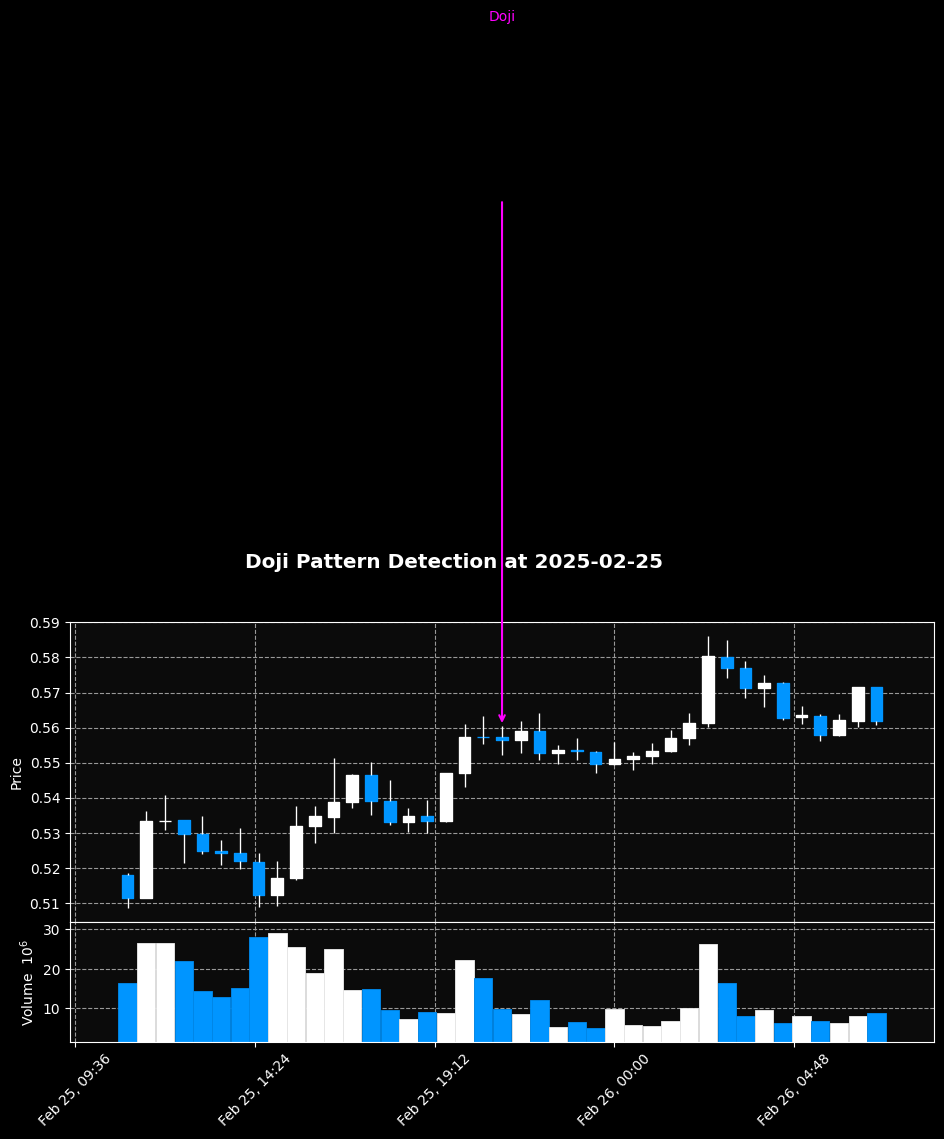

In [63]:
plot_random_pattern(data, 'doji', 'Doji')

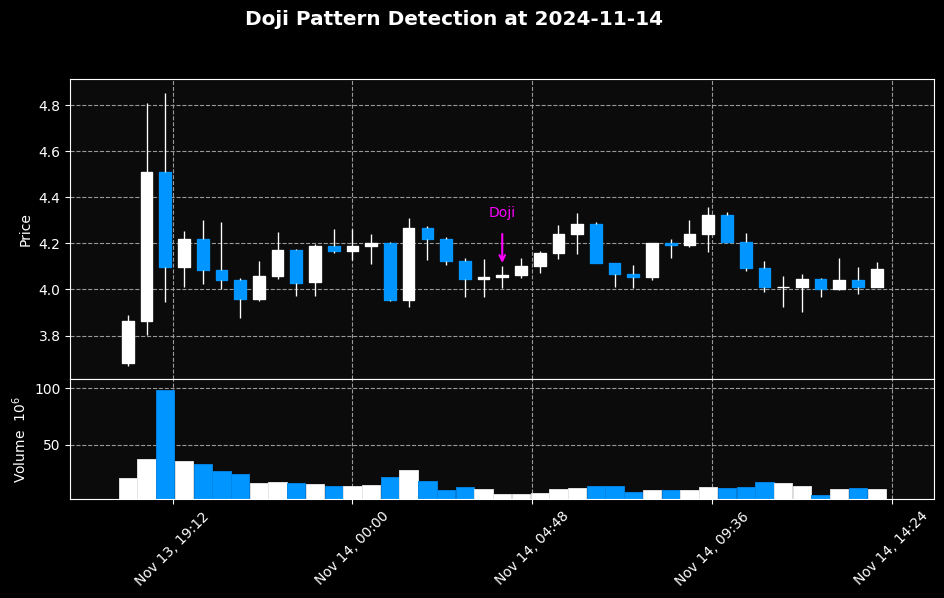

In [64]:
plot_random_pattern(data_v2, 'doji', 'Doji')

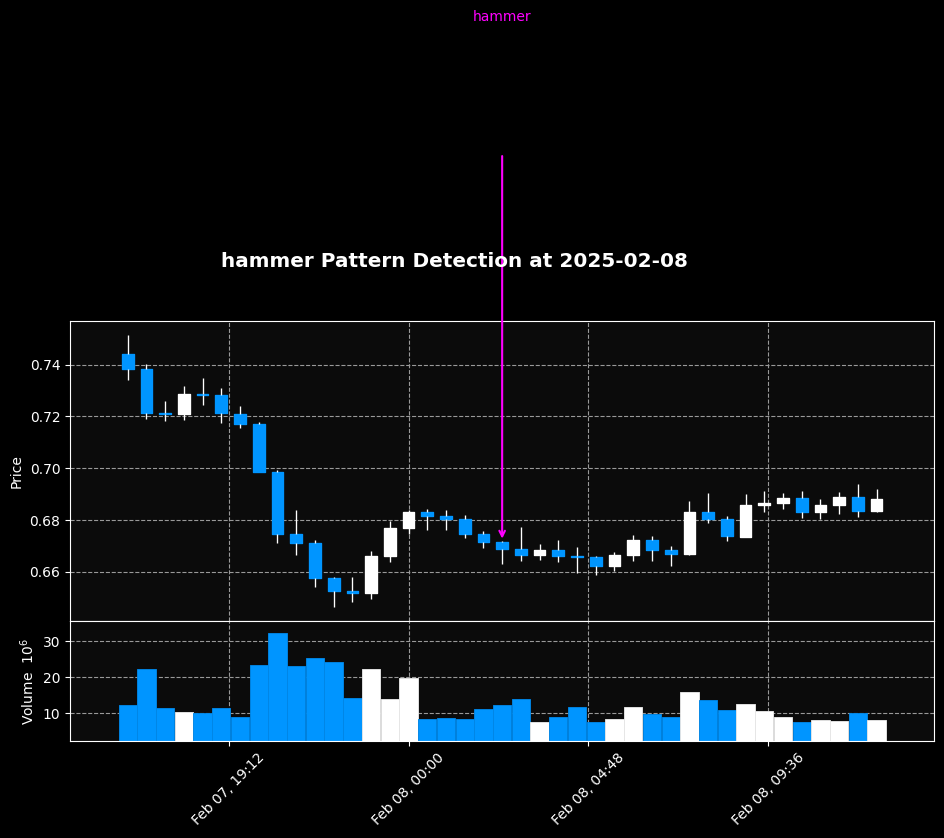

In [65]:
# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

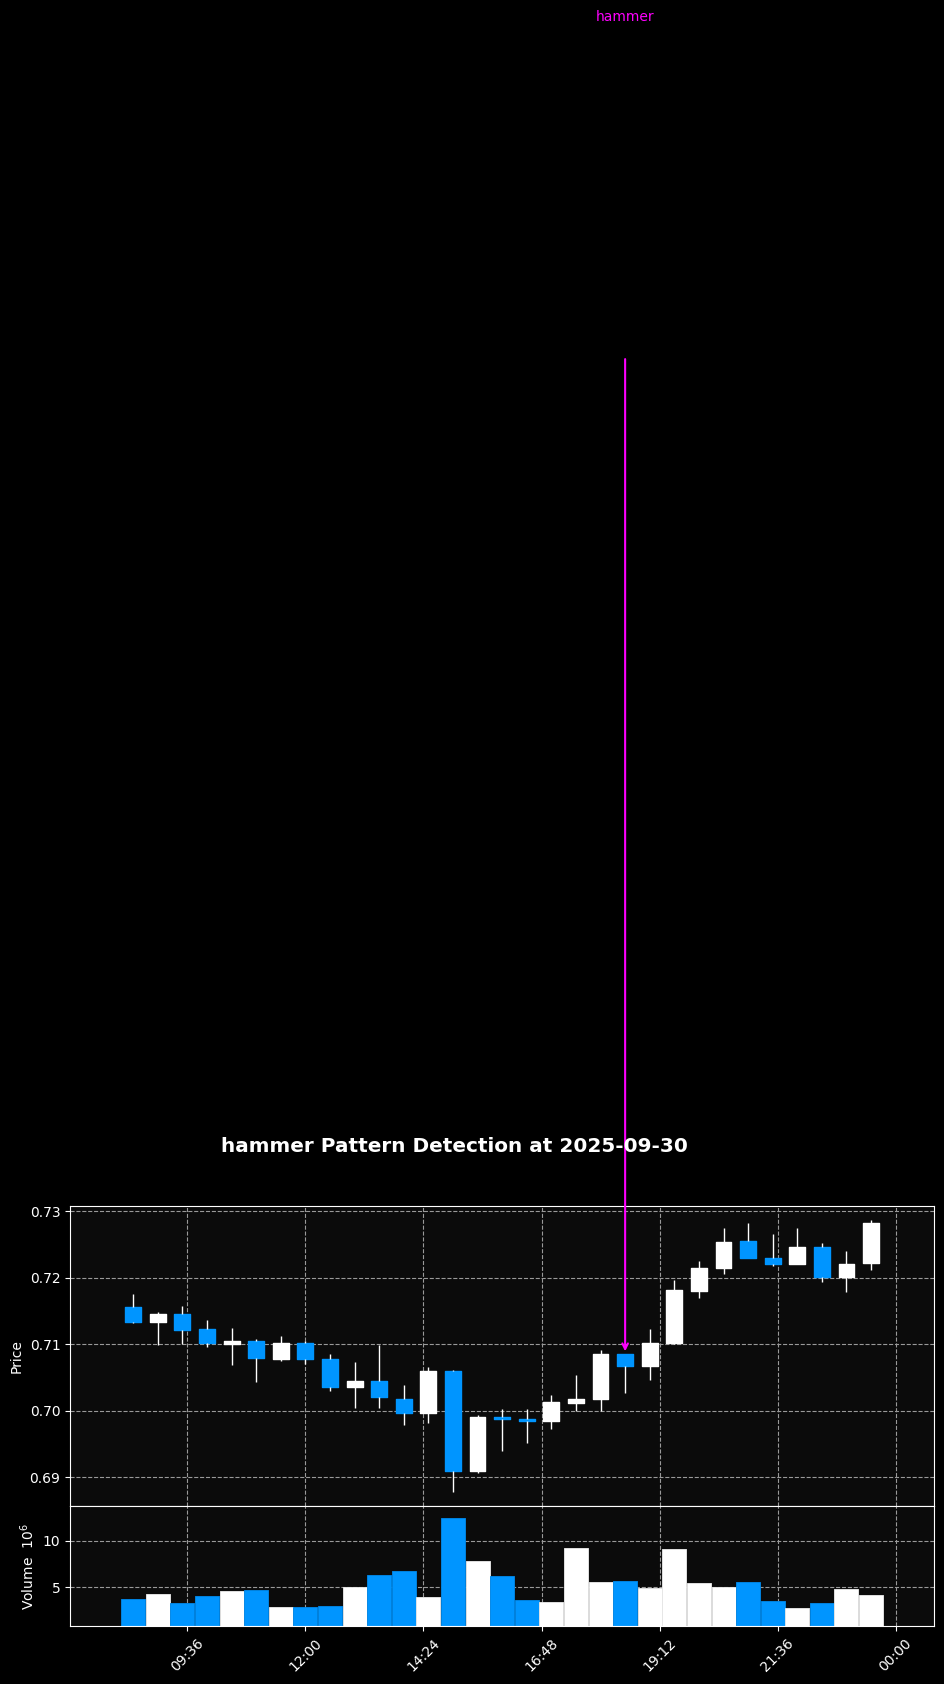

In [66]:
plot_random_pattern(data_v2, 'hammer', 'hammer')

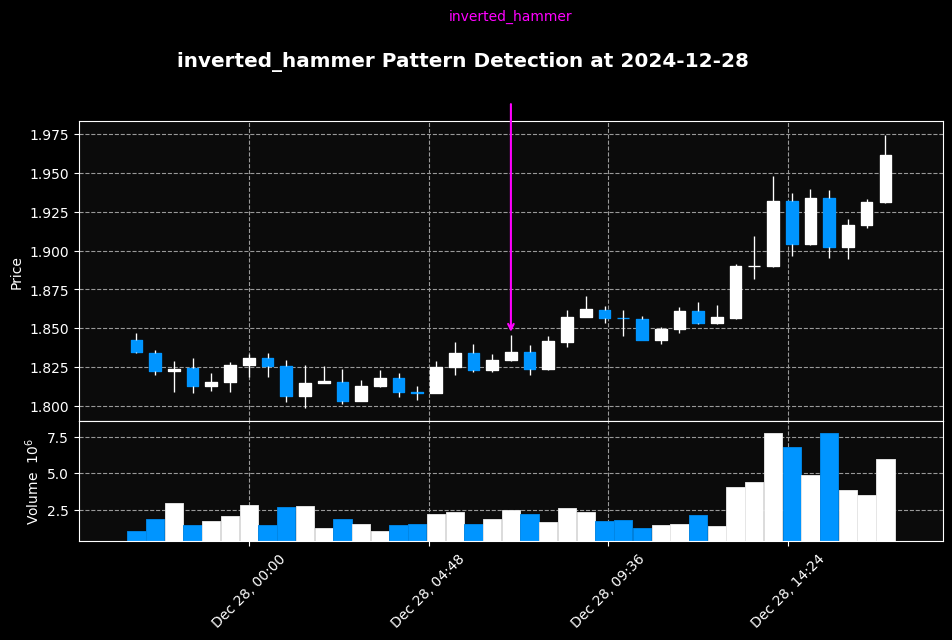

In [67]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

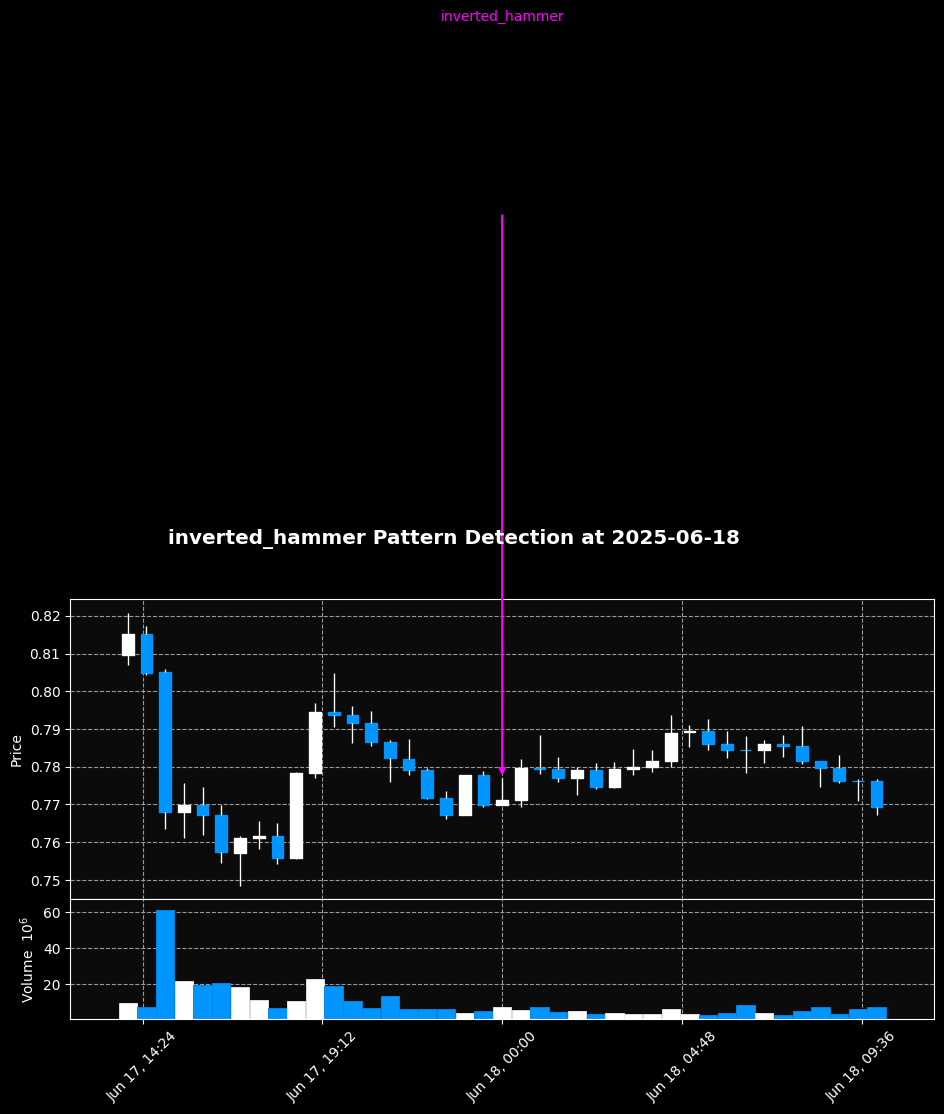

In [68]:
plot_random_pattern(data_v2, 'inverted_hammer', 'inverted_hammer')

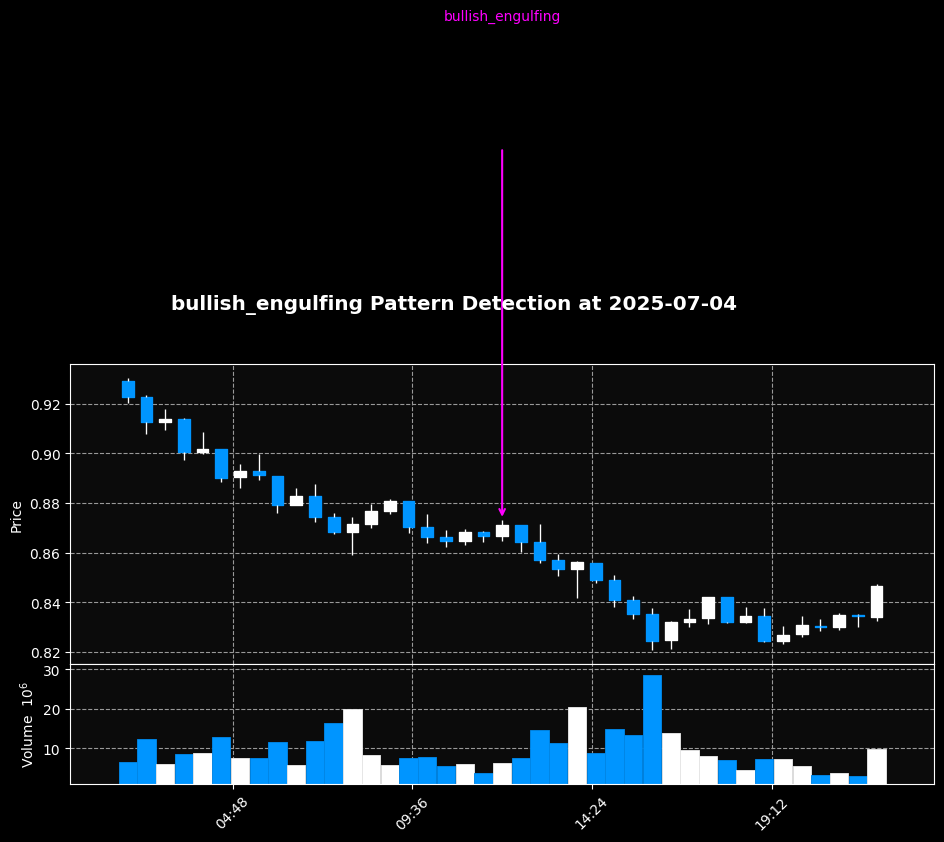

In [69]:
plot_random_pattern(data, 'bullish_engulfing', 'bullish_engulfing')

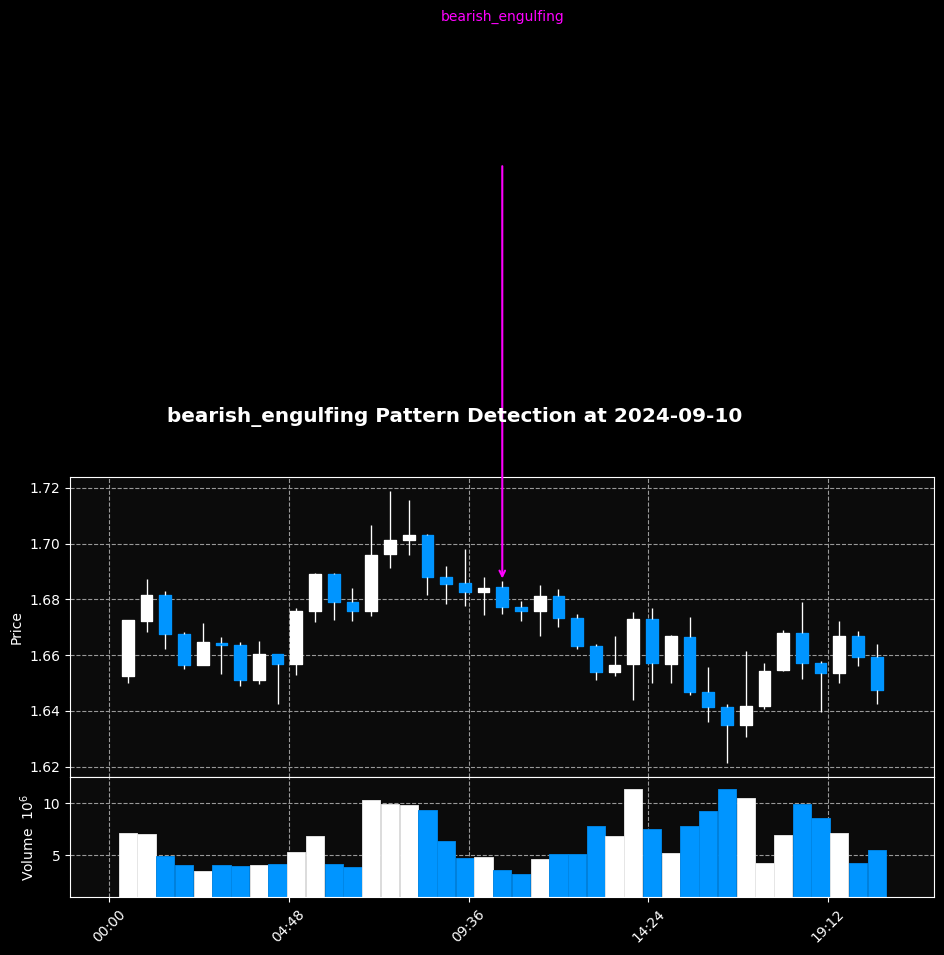

In [70]:
plot_random_pattern(data, 'bearish_engulfing', 'bearish_engulfing')

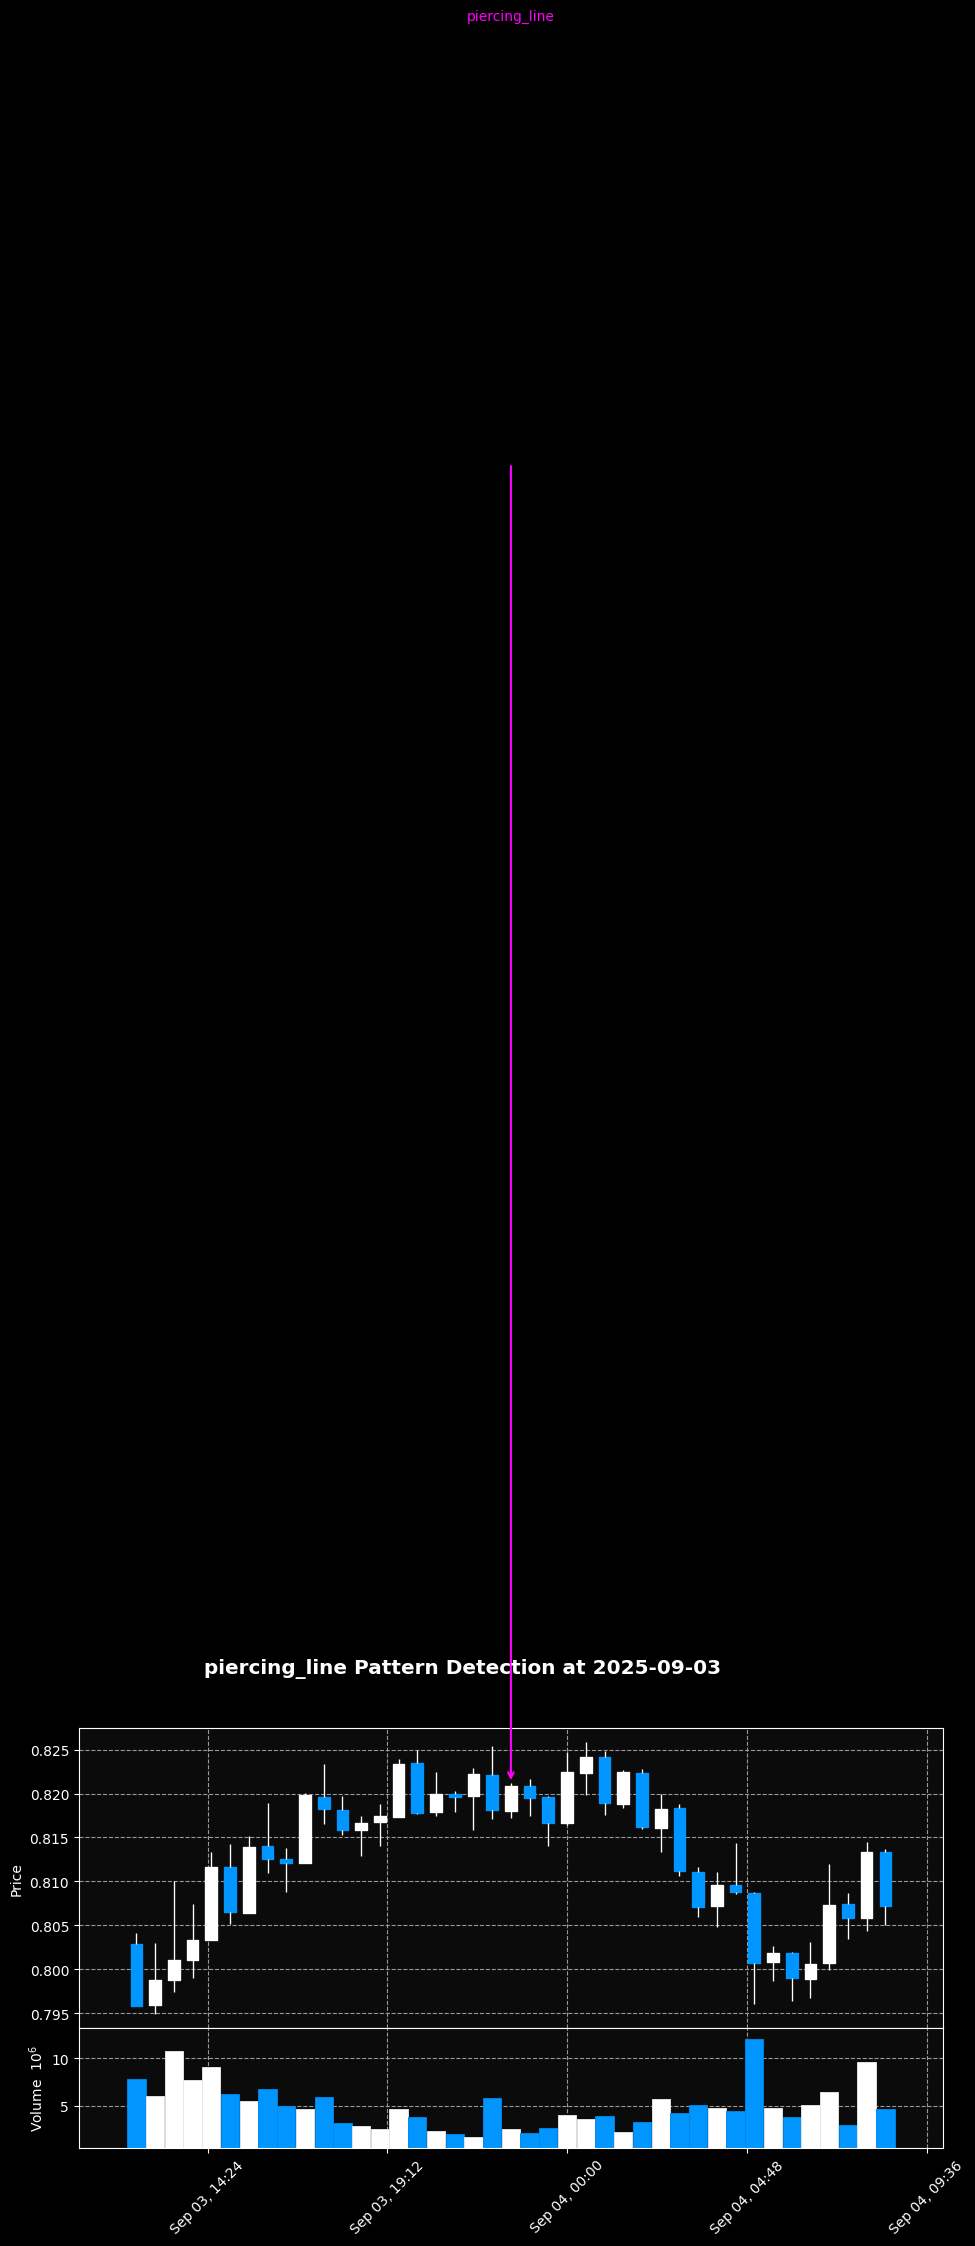

In [71]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

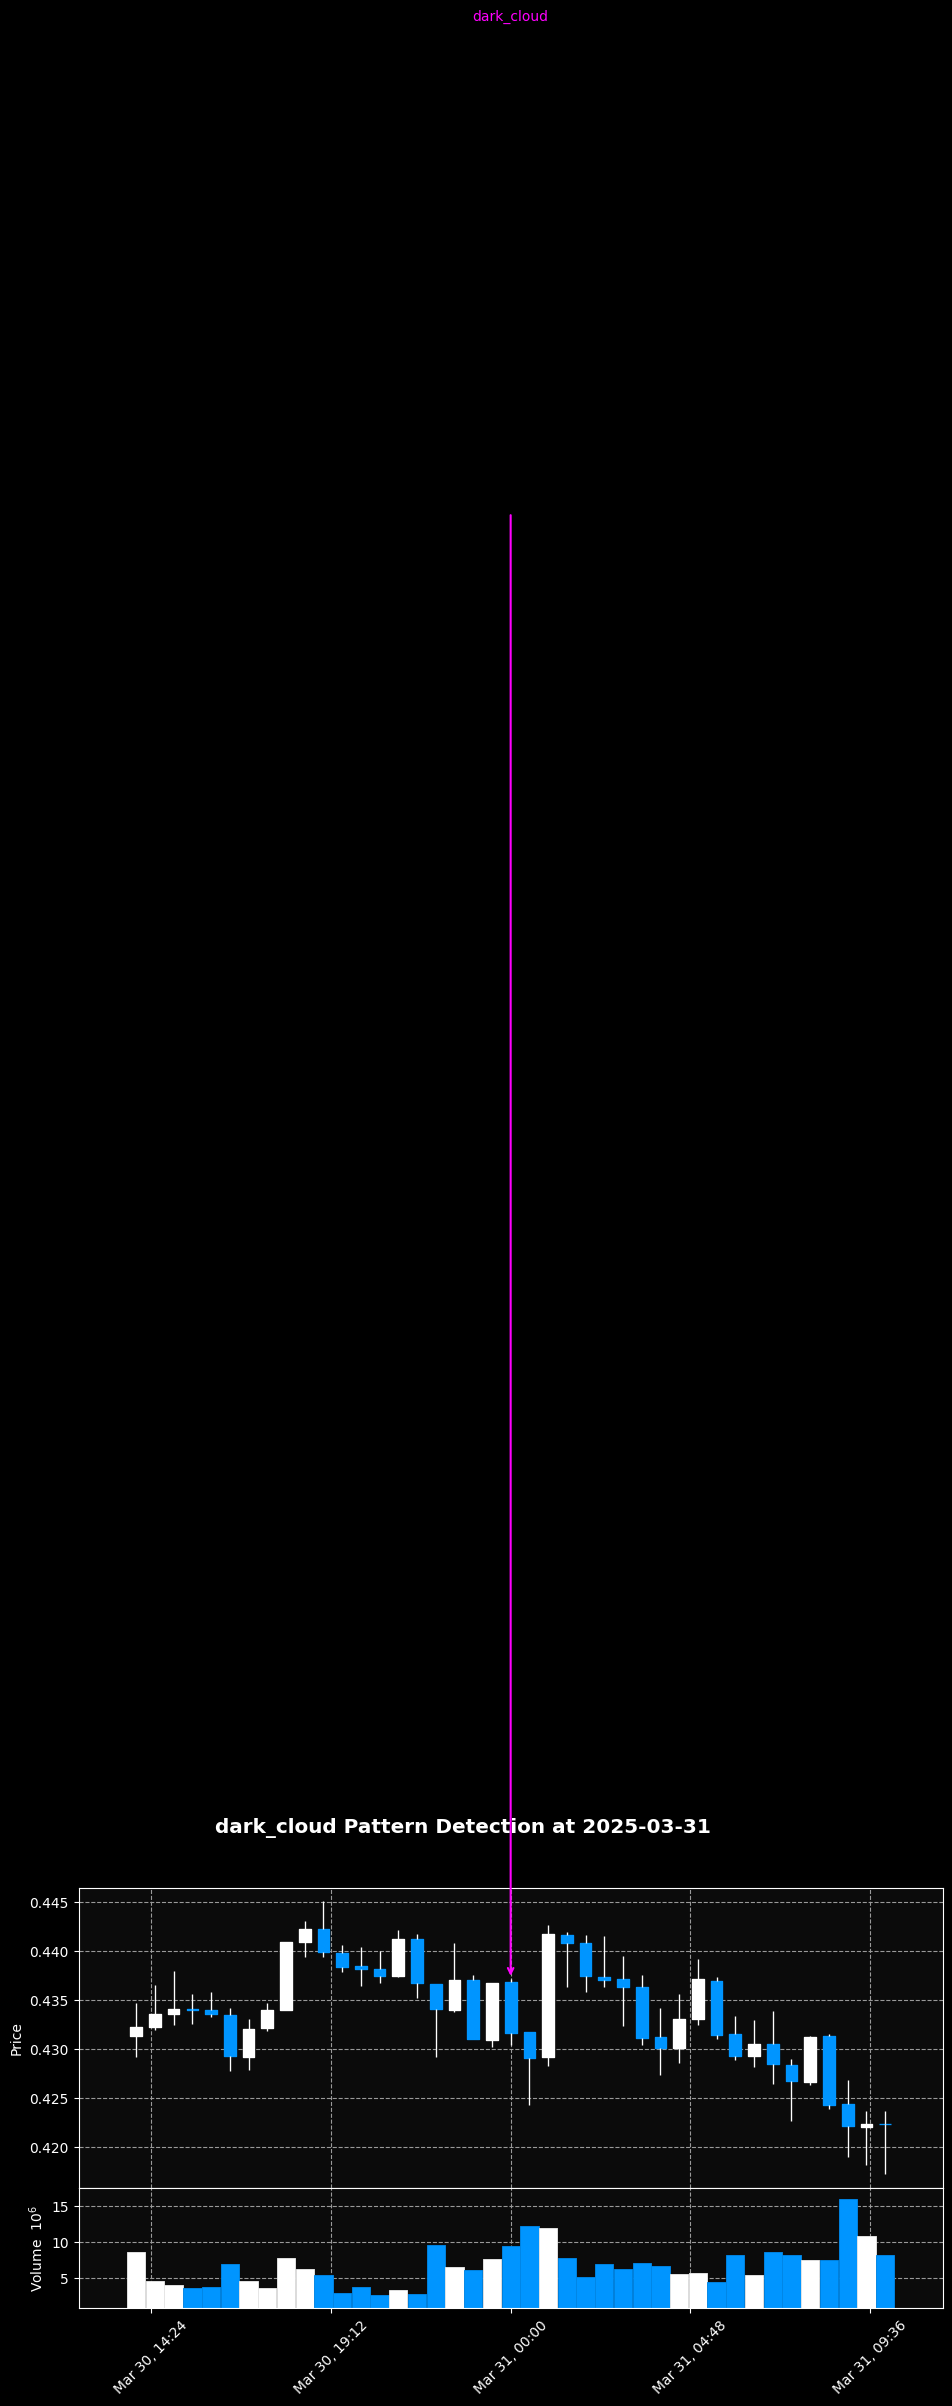

In [72]:
plot_random_pattern(data, 'dark_cloud', 'dark_cloud')

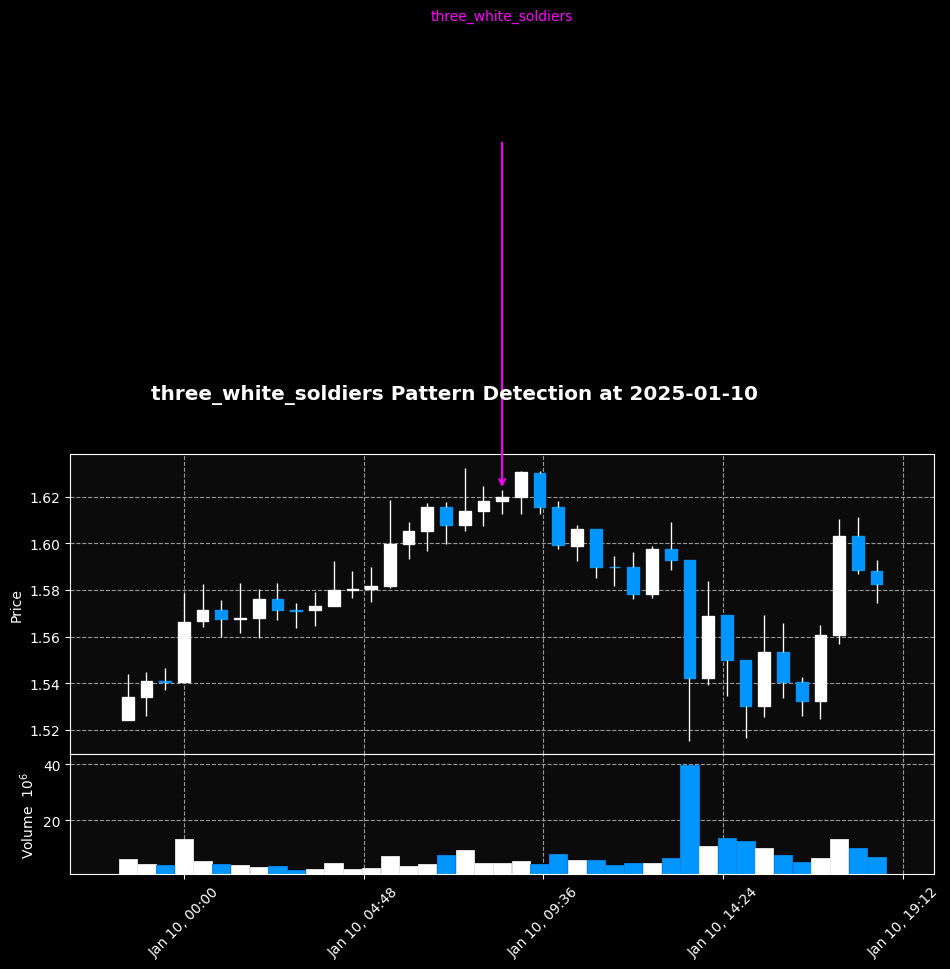

In [73]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

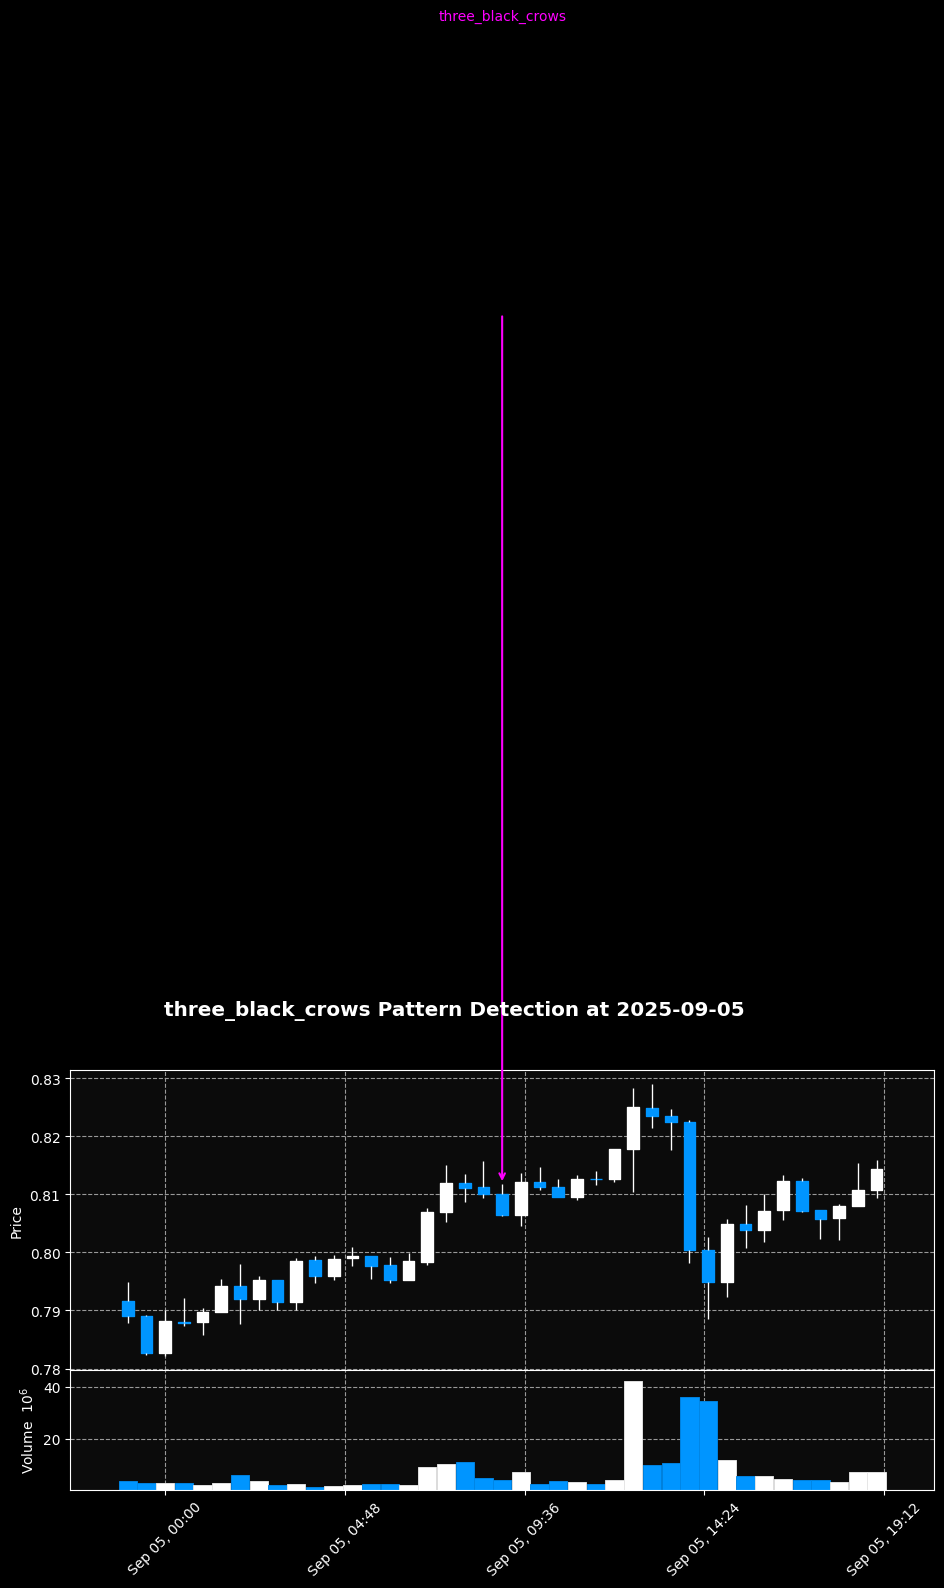

In [74]:
plot_random_pattern(data, 'three_black_crows', 'three_black_crows')

In [75]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

No occurences of harami_cross pattern found.


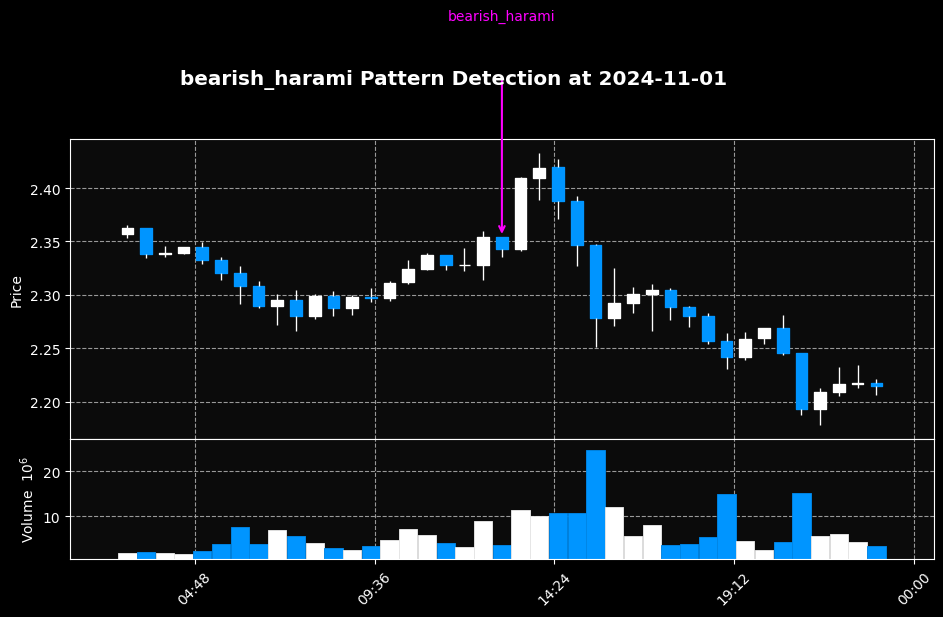

In [76]:
plot_random_pattern(data, 'bearish_harami', 'bearish_harami')

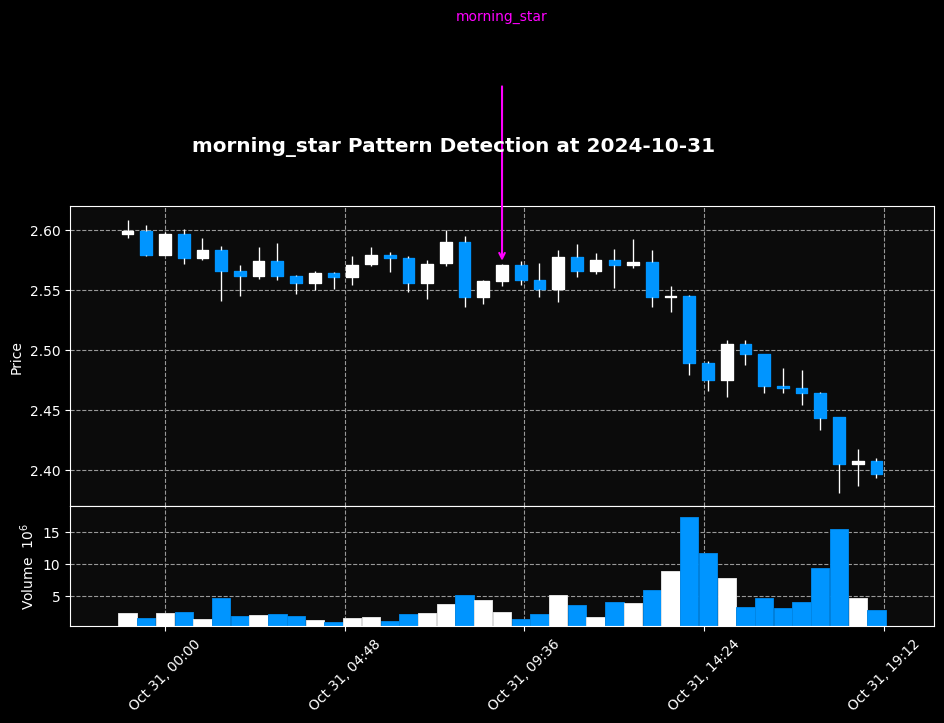

In [77]:
plot_random_pattern(data, 'morning_star', 'morning_star')

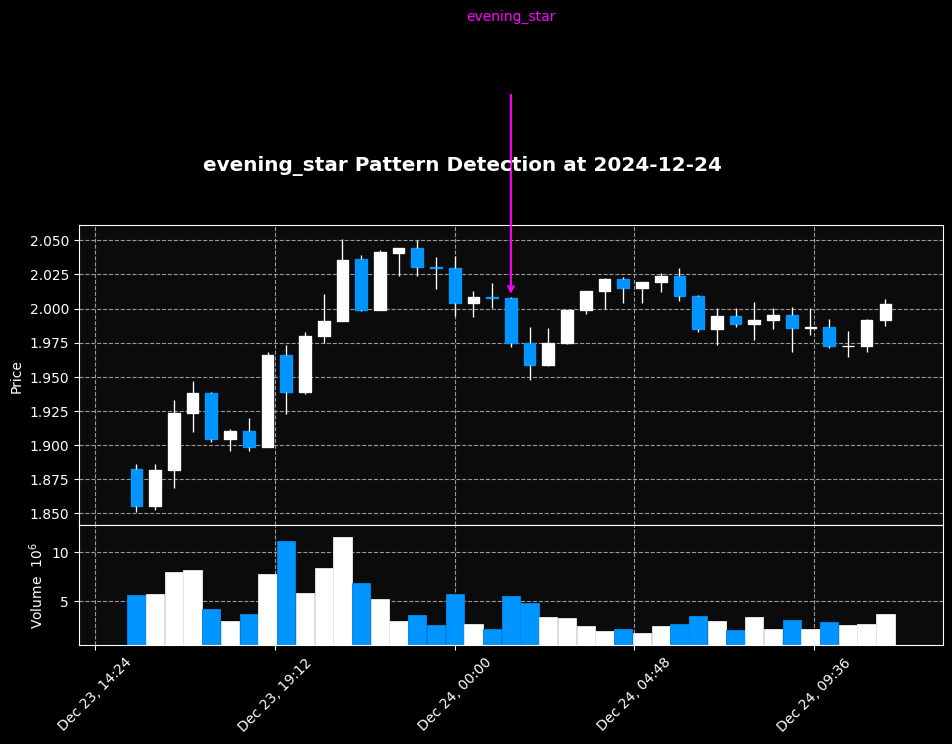

In [78]:
plot_random_pattern(data, 'evening_star', 'evening_star')

Patterns count

In [79]:
# Считаем количество True для всех свечных паттернов
pattern_cols = [
    "doji", "hammer", "inverted_hammer", "three_white_soldiers", "three_black_crows",
    "bullish_engulfing", "bearish_engulfing", "dark_cloud", "harami_cross",
    "morning_star", "evening_star", "piercing_line", "bearish_harami"
]

pattern_counts = {col: int(data[col].sum()) for col in pattern_cols}

# Печатаем статистику
for col, count in pattern_counts.items():
    print(f"{col.replace('_', ' ').title()} patterns: {count}")

print(f"\nTotal patterns: {sum(pattern_counts.values())}")

# Удаляем колонки, где нет ни одного сигнала
for col, count in pattern_counts.items():
    if count == 0:
        data.drop(columns=[col], inplace=True)


Doji patterns: 2028
Hammer patterns: 270
Inverted Hammer patterns: 299
Three White Soldiers patterns: 1915
Three Black Crows patterns: 2304
Bullish Engulfing patterns: 645
Bearish Engulfing patterns: 634
Dark Cloud patterns: 1
Harami Cross patterns: 0
Morning Star patterns: 834
Evening Star patterns: 794
Piercing Line patterns: 931
Bearish Harami patterns: 11

Total patterns: 10666


# Backtesting

In [80]:
df = data.copy()

# 1) Переименовываем только OHLC(V) в формат, который требует backtesting.py
rename_map = {}
if 'open' in df.columns:
    rename_map['open'] = 'Open'
if 'high' in df.columns:
    rename_map['high'] = 'High'
if 'low' in df.columns:
    rename_map['low'] = 'Low'
if 'close' in df.columns:
    rename_map['close'] = 'Close'
if 'volume' in df.columns:
    rename_map['volume'] = 'Volume'

df = df.rename(columns=rename_map)

In [81]:
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [82]:
bullish_patterns = [
    'hammer', 'inverted_hammer', 'bullish_engulfing',
    'piercing_line', 'morning_star', 'three_white_soldiers'
]
bearish_patterns = [
    'bearish_engulfing', 'dark_cloud', 'evening_star',
    'three_black_crows', 'bearish_harami'
]

In [83]:
# Если каких-то колонок-паттернов нет — создадим их как False (без падения)
for col in set(bullish_patterns + bearish_patterns):
    if col not in df.columns:
        df[col] = False


# Формируем одну колонку Signal: 1 = long, -1 = short, 0 = нет сигнала
df['Signal'] = 0
df.loc[df[bullish_patterns].any(axis=1), 'Signal'] = 1
df.loc[df[bearish_patterns].any(axis=1), 'Signal'] = -1

In [84]:
atr_period = 14
df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=atr_period)

In [85]:
# Удалим строки с NaN в OHLC (backtesting.py требует полные свечи)
df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

### Basic

In [86]:
import numpy as np
import pandas as pd
import talib
from backtesting import Backtest, Strategy

# ====== Подготовка DataFrame (подставь свой data) ======
# data — DataFrame, который получил после detect_candlestick_patterns(...)
df = data.copy()

# 1) Переименовываем только OHLC(V) в формат, который требует backtesting.py
rename_map = {}
if 'open' in df.columns:
    rename_map['open'] = 'Open'
if 'high' in df.columns:
    rename_map['high'] = 'High'
if 'low' in df.columns:
    rename_map['low'] = 'Low'
if 'close' in df.columns:
    rename_map['close'] = 'Close'
if 'volume' in df.columns:
    rename_map['volume'] = 'Volume'

df = df.rename(columns=rename_map)

# 2) Убедимся, что индекс — DatetimeIndex и отсортирован
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
df = df.sort_index()

# 3) Проверка обязательных колонок
required = {'Open', 'High', 'Low', 'Close'}
if not required.issubset(set(df.columns)):
    missing = required - set(df.columns)
    raise ValueError(f"DataFrame missing required OHLC columns: {missing}")

# ====== Собираем сигналы (Signal) на основании паттернов ======
bullish_patterns = [
    'hammer', 'inverted_hammer', 'bullish_engulfing',
    'piercing_line', 'morning_star', 'three_white_soldiers'
]
bearish_patterns = [
    'bearish_engulfing', 'dark_cloud', 'evening_star',
    'three_black_crows', 'bearish_harami'
]

# Если каких-то колонок-паттернов нет — создадим их как False (без падения)
for col in set(bullish_patterns + bearish_patterns):
    if col not in df.columns:
        df[col] = False

# Формируем одну колонку Signal: 1 = long, -1 = short, 0 = нет сигнала
df['Signal'] = 0
df.loc[df[bullish_patterns].any(axis=1), 'Signal'] = 1
df.loc[df[bearish_patterns].any(axis=1), 'Signal'] = -1

# ====== Рассчитываем ATR (TA-Lib) ======
atr_period = 14
df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=atr_period)

# Удалим строки с NaN в OHLC (backtesting.py требует полные свечи)
df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

# ====== Strategy для backtesting.py ======
class PatternATRStrategy(Strategy):
    atr_period = atr_period
    stop_atr = 0.75
    take_atr = 0.75 # можно менять

    def init(self):
        # вычислим ATR как индикатор (чтобы он был выровнен по индексу)
        self.atr = self.I(
            lambda H, L, C: talib.ATR(H, L, C, timeperiod=self.atr_period),
            self.data.High, self.data.Low, self.data.Close
        )
        # скопируем Signal в индикатор для удобного доступа
        # backtesting.Data позволяет обращаться к дополнительным колонкам через self.data.df
        # используем self.I, чтобы получить выровненный массив
        self.signal = self.I(lambda s: s.values, self.data.df['Signal'])
        self.stop_atr = self.stop_atr
        self.take_atr = self.take_atr

    def next(self):
        atr = self.atr[-1]
        sig = int(self.signal[-1])  # 1, -1 или 0
        price = self.data.Close[-1]

        # если ATR ещё nan — не торгуем
        if np.isnan(atr):
            return

        # Если нет открытой позиции — выставляем ордер по сигналу
        if not self.position:
            if sig == 1:
                sl = price - self.stop_atr * atr
                tp = price + self.take_atr * atr
                # trade_on_close=True — исполнение по close текущей свечи
                self.buy(sl=sl, tp=tp)
            elif sig == -1:
                sl = price + self.stop_atr * atr
                tp = price - self.take_atr * atr
                self.sell(sl=sl, tp=tp)
        # если позиция открыта, backtesting.py сам отслеживает SL/TP, закрытие не нужно дописывать здесь

# ====== Запуск бэктеста ======
bt = Backtest(
    df,
    PatternATRStrategy,
    cash=1_000_000,
    commission=0.0005,      # пример комиссии
    trade_on_close=True,    # вход по close свечи, где обнаружен паттерн
    exclusive_orders=True   # одна открытая позиция за раз
)

stats = bt.run()
print(stats)      # сводка метрик
# bt.plot(open_browser=False)   # откроет график в jupyter / локально

Backtest.run:   0%|          | 0/18945 [00:00<?, ?bar/s]

Start                     2024-09-01 00:00...
End                       2025-09-30 23:30...
Duration                    394 days 23:30:00
Exposure Time [%]                    74.78376
Equity Final [$]                   2167.96218
Equity Peak [$]                 1019494.79497
Commissions [$]                  695440.41023
Return [%]                           -99.7832
Buy & Hold Return [%]               -50.69068
Return (Ann.) [%]                   -99.65566
Volatility (Ann.) [%]                 0.34659
CAGR [%]                            -99.65466
Sharpe Ratio                       -287.52782
Sortino Ratio                        -1.34499
Calmar Ratio                         -0.99862
Alpha [%]                           -98.92138
Beta                                    0.017
Max. Drawdown [%]                    -99.7934
Avg. Drawdown [%]                   -25.67907
Max. Drawdown Duration      393 days 20:00:00
Avg. Drawdown Duration       98 days 14:53:00
# Trades                          

### Indicators

In [87]:
import numpy as np
import pandas as pd
import talib
from backtesting import Backtest, Strategy

class PatternIndicatorsStrategy(Strategy):
    # --- параметры (подбирай / оптимизируй) ---
    atr_period = 14

    # трендовые EMAs
    ema_fast_period = 50
    ema_slow_period = 200
    require_trend = True

    # подтверждение (breakout confirmation)
    require_confirmation = True
    confirmation_buf = 0.0005

    # объём
    use_volume_filter = False
    vol_ma_period = 20
    vol_mult = 1.15

    # S/R proximity
    use_sr_filter = False
    sr_lookback = 50
    sr_atr_mult = 1.0

    # минимальный "вес" паттерна
    min_body_atr = 0.05

    # ADX / volatility filters
    use_adx = False
    adx_period = 14
    adx_threshold = 20

    # риск-менеджмент
    risk_per_trade = 0.005
    min_fraction = 0.001
    max_fraction = 0.2

    # misc
    min_atr_ratio = 0.0001

    def init(self):
        # Ссылка на "сырые" данные (pandas DataFrame) — безопасно
        self._df = self.data.df

        # удостоверься, что необходимые столбцы есть
        if not {'High', 'Low', 'Close', 'Open'}.issubset(self._df.columns):
            raise ValueError("DataFrame must contain 'High','Low','Close','Open' columns")

        # series для индикаторов (pandas Series)
        H = self._df['High']
        L = self._df['Low']
        C = self._df['Close']
        O = self._df['Open']
        V = self._df['Volume'] if 'Volume' in self._df.columns else None

        # индикаторы (через self.I -> выровненные массивы)
        self.atr = self.I(lambda H, L, C: talib.ATR(H, L, C, timeperiod=self.atr_period), H, L, C)
        self.ema_fast = self.I(talib.EMA, C, self.ema_fast_period)
        self.ema_slow = self.I(talib.EMA, C, self.ema_slow_period)

        if self.use_adx:
            self.adx = self.I(lambda H, L, C: talib.ADX(H, L, C, timeperiod=self.adx_period), H, L, C)
        else:
            self.adx = None

        # volume MA (если есть Volume)
        if V is not None and self.use_volume_filter:
            self.vol_ma = self.I(lambda vol, period=self.vol_ma_period:
                                 pd.Series(vol).rolling(period).mean().values, V)
        else:
            self.vol_ma = None

        # rolling S/R на основе Close
        self.roll_min = self.I(lambda c, lookback=self.sr_lookback:
                               pd.Series(c).rolling(lookback).min().values, C)
        self.roll_max = self.I(lambda c, lookback=self.sr_lookback:
                               pd.Series(c).rolling(lookback).max().values, C)

        # тело свечи (выровнённый массив)
        self.body = self.I(lambda o, c: np.abs(c - o), O, C)

        # сигнал из внешней колонки Signal — берем "сырую" колонку, её наличие гарантируем в основном коде
        if 'Signal' not in self._df.columns:
            # если нет — создадим нулевую колонку
            self._df['Signal'] = 0
        # нет необходимости применять self.I для Signal — используем _df напрямую в next()
        # но можно сохранить ссылку:
        self._signal_series = self._df['Signal']



    def next(self):
        i = len(self.data) - 1  # индекс текущей свечи в обработчике

        # нужно как минимум 1 предыдущая свеча, если требуется подтверждение
        if self.require_confirmation and i < 1:
            return

        # текущие значения
        price = self.data.Close[-1]
        atr = self.atr[-1]

        if np.isnan(atr) or np.isnan(price):
            return

        # базовая волатильность
        if (atr / price) < self.min_atr_ratio:
            return

        # получаем сигнал (в предыдущей свече при require_confirmation)
        if self.require_confirmation:
            sig = int(self._signal_series.iat[i - 1])
            prev_high = self._df['High'].iat[i - 1]
            prev_low = self._df['Low'].iat[i - 1]

            # подтверждение — пробой high/low предыдущей свечи
            confirmed_long = (price > prev_high * (1.0 + self.confirmation_buf))
            confirmed_short = (price < prev_low * (1.0 - self.confirmation_buf))

            if sig == 1 and not confirmed_long:
                return
            if sig == -1 and not confirmed_short:
                return
        else:
            sig = int(self._signal_series.iat[i])

        if sig == 0:
            return

        # трендовый фильтр
        if self.require_trend:
            if np.isnan(self.ema_fast[-1]) or np.isnan(self.ema_slow[-1]):
                return
            if sig == 1 and not (self.ema_fast[-1] > self.ema_slow[-1]):
                return
            if sig == -1 and not (self.ema_fast[-1] < self.ema_slow[-1]):
                return

        # ADX (опционально)
        if self.use_adx and (not np.isnan(self.adx[-1])) and (self.adx[-1] < self.adx_threshold):
            return

        # volume filter
        if self.vol_ma is not None and 'Volume' in self._df.columns:
            vol = self._df['Volume'].iat[i]
            if np.isnan(self.vol_ma[-1]) or vol <= self.vol_ma[-1] * self.vol_mult:
                return

        # S/R proximity
        if self.use_sr_filter:
            if sig == 1:
                local_min = self.roll_min[-1]
                if np.isnan(local_min) or abs(price - local_min) > self.sr_atr_mult * atr:
                    return
            else:
                local_max = self.roll_max[-1]
                if np.isnan(local_max) or abs(price - local_max) > self.sr_atr_mult * atr:
                    return

        # минимальный вес паттерна: возьмём тело свечи, где был паттерн
        body_idx = -2 if self.require_confirmation else -1
        # надо убедиться, что индекс body_idx существует
        if len(self.body) < abs(body_idx):
            return
        if self.body[body_idx] < self.min_body_atr * atr:
            return

        # SL/TP (уровни)
        if sig == 1:
            sl = price - 0.45 * atr
            tp = price + 2.5 * atr
            stop_distance = price - sl
        else:
            sl = price + 0.45 * atr
            tp = price - 2.5 * atr
            stop_distance = sl - price

        if stop_distance <= 0 or np.isnan(stop_distance):
            return

        # размер позиции по риску (fraction of equity)
        frac = (self.risk_per_trade * price) / stop_distance
        frac = float(np.clip(frac, 0.0, self.max_fraction))

        if frac < self.min_fraction:
            return

        # выставляем ордер
        if sig == 1:
            self.buy(size=frac, sl=sl, tp=tp)
        else:
            self.sell(size=frac, sl=sl, tp=tp)



bt = Backtest(
    df,
    PatternIndicatorsStrategy,
    cash=1_000_000,
    commission=0.0005,      # пример комиссии
    trade_on_close=True,    # вход по close свечи, где обнаружен паттерн
    exclusive_orders=True   # одна открытая позиция за раз
)


stats = bt.run()
print(stats)

Backtest.run:   0%|          | 0/18760 [00:00<?, ?bar/s]

Start                     2024-09-01 00:00...
End                       2025-09-30 23:30...
Duration                    394 days 23:30:00
Exposure Time [%]                    15.94937
Equity Final [$]                 883006.31929
Equity Peak [$]                 1000000.62867
Commissions [$]                  197593.33578
Return [%]                          -11.69937
Buy & Hold Return [%]               -53.39222
Return (Ann.) [%]                   -10.86099
Volatility (Ann.) [%]                 8.56446
CAGR [%]                            -10.86153
Sharpe Ratio                         -1.26815
Sortino Ratio                        -1.96332
Calmar Ratio                         -0.77267
Alpha [%]                           -11.76061
Beta                                 -0.00115
Max. Drawdown [%]                   -14.05643
Avg. Drawdown [%]                    -7.40452
Max. Drawdown Duration      385 days 15:30:00
Avg. Drawdown Duration      195 days 01:00:00
# Trades                          

### V2

In [88]:
df = data_v2.copy()

# 1) Переименовываем только OHLC(V) в формат, который требует backtesting.py
rename_map = {}
if 'open' in df.columns:
    rename_map['open'] = 'Open'
if 'high' in df.columns:
    rename_map['high'] = 'High'
if 'low' in df.columns:
    rename_map['low'] = 'Low'
if 'close' in df.columns:
    rename_map['close'] = 'Close'
if 'volume' in df.columns:
    rename_map['volume'] = 'Volume'

df = df.rename(columns=rename_map)

In [89]:
import numpy as np
import pandas as pd
import talib
from backtesting import Backtest, Strategy

class PatternStrategyV2(Strategy):
    # === параметры стратегии ===
    atr_period = 14
    ema_fast = 50
    ema_slow = 200
    confirmation_buf = 0.001
    require_confirmation = True
    require_trend = True
    use_volume_filter = True
    vol_mult = 1.15
    vol_ma_period = 20
    use_adx = False
    adx_period = 14
    adx_threshold = 20
    use_sr_filter = False
    sr_lookback = 50
    sr_atr_mult = 1.0
    min_signal_strength = 0.4     # минимальная сила сигнала из detect_candlestick_patterns_v2
    risk_per_trade = 0.005
    max_fraction = 0.2
    min_fraction = 0.001

    def init(self):
        df = self.data.df
        self.df = df

        # Проверим наличие нужных колонок
        required_cols = {'Open','High','Low','Close','Signal','Signal_strength','ATR'}
        missing = required_cols - set(df.columns)
        if missing:
            raise ValueError(f"Отсутствуют колонки: {missing}")

        # Базовые индикаторы
        H, L, C, O = df['High'], df['Low'], df['Close'], df['Open']

        self.ema_fast_line = self.I(talib.EMA, C, self.ema_fast)
        self.ema_slow_line = self.I(talib.EMA, C, self.ema_slow)
        self.atr = self.I(lambda h,l,c: talib.ATR(h,l,c, timeperiod=self.atr_period), H,L,C)

        if self.use_adx:
            self.adx = self.I(lambda h,l,c: talib.ADX(h,l,c,timeperiod=self.adx_period), H,L,C)
        else:
            self.adx = None

        if 'Volume' in df.columns and self.use_volume_filter:
            self.vol_ma = self.I(lambda v: pd.Series(v).rolling(self.vol_ma_period).mean().values, df['Volume'])
        else:
            self.vol_ma = None

        if self.use_sr_filter:
            self.sr_min = self.I(lambda c: pd.Series(c).rolling(self.sr_lookback).min().values, C)
            self.sr_max = self.I(lambda c: pd.Series(c).rolling(self.sr_lookback).max().values, C)
        else:
            self.sr_min = None
            self.sr_max = None

    def next(self):
        i = len(self.data) - 1
        price = self.data.Close[-1]
        atr = self.atr[-1]

        if np.isnan(price) or np.isnan(atr):
            return

        # Сигнал и сила
        if self.require_confirmation and i < 1:
            return
        sig = int(self.df['Signal'].iat[i - 1] if self.require_confirmation else self.df['Signal'].iat[i])
        sig_strength = float(self.df['Signal_strength'].iat[i - 1] if self.require_confirmation else self.df['Signal_strength'].iat[i])

        if sig == 0 or sig_strength < self.min_signal_strength:
            return

        # подтверждение
        if self.require_confirmation:
            prev_high = self.df['High'].iat[i - 1]
            prev_low = self.df['Low'].iat[i - 1]
            confirmed = (
                (sig == 1 and price > prev_high * (1.0 + self.confirmation_buf)) or
                (sig == -1 and price < prev_low * (1.0 - self.confirmation_buf))
            )
            if not confirmed:
                return

        # тренд
        if self.require_trend:
            if sig == 1 and not (self.ema_fast_line[-1] > self.ema_slow_line[-1]):
                return
            if sig == -1 and not (self.ema_fast_line[-1] < self.ema_slow_line[-1]):
                return

        # ADX
        if self.use_adx and self.adx is not None:
            if np.isnan(self.adx[-1]) or self.adx[-1] < self.adx_threshold:
                return

        # объём
        if self.vol_ma is not None and 'Volume' in self.df.columns:
            vol = self.df['Volume'].iat[i]
            if np.isnan(self.vol_ma[-1]) or vol <= self.vol_ma[-1] * self.vol_mult:
                return

        # фильтр S/R
        if self.use_sr_filter and self.sr_min is not None and self.sr_max is not None:
            if sig == 1:
                dist = abs(price - self.sr_min[-1])
            else:
                dist = abs(price - self.sr_max[-1])
            if dist > self.sr_atr_mult * atr:
                return

        # --- риск-менеджмент ---
        if sig == 1:
            sl = price - 0.5 * atr
            tp = price + 2.5 * atr
            stop_dist = price - sl
        else:
            sl = price + 0.5 * atr
            tp = price - 2.5 * atr
            stop_dist = sl - price

        if stop_dist <= 0:
            return

        frac = (self.risk_per_trade * price) / stop_dist
        frac *= np.clip(sig_strength, 0.3, 1.5)  # сила сигнала увеличивает/уменьшает размер
        frac = float(np.clip(frac, self.min_fraction, self.max_fraction))

        # --- вход ---
        if sig == 1:
            self.buy(size=frac, sl=sl, tp=tp)
        elif sig == -1:
            self.sell(size=frac, sl=sl, tp=tp)


In [90]:
bt = Backtest(
    df,  # DataFrame после detect_candlestick_patterns_v2
    PatternStrategyV2,
    cash=1_000_000,
    commission=0.0005,
    trade_on_close=True,
    exclusive_orders=True,
)

stats = bt.run()
# bt.plot()
print(stats)


Backtest.run:   0%|          | 0/18760 [00:00<?, ?bar/s]

Start                     2024-09-01 00:00...
End                       2025-09-30 23:30...
Duration                    394 days 23:30:00
Exposure Time [%]                     7.96941
Equity Final [$]                 879973.72016
Equity Peak [$]                  1010581.9473
Commissions [$]                    86396.2438
Return [%]                          -12.00263
Buy & Hold Return [%]               -53.39222
Return (Ann.) [%]                   -11.14391
Volatility (Ann.) [%]                 6.56136
CAGR [%]                            -11.14446
Sharpe Ratio                         -1.69841
Sortino Ratio                        -2.94012
Calmar Ratio                         -0.86226
Alpha [%]                           -12.16776
Beta                                 -0.00309
Max. Drawdown [%]                   -12.92406
Avg. Drawdown [%]                    -2.56551
Max. Drawdown Duration      368 days 18:30:00
Avg. Drawdown Duration       64 days 15:10:00
# Trades                          